# Shelter Animals Outcomes

**Final Project
<br>
W207- Applied Machine Learning
<br>
Danielle Adler, Alla Hale, John Pette**

For our Kaggle dataset research project, we chose to focus on the Shelter Animal Outcome project at the following link: https://www.kaggle.com/c/shelter-animal-outcomes#description. As our whole team cares about animals and is trying to use data to harness social good, we decided to use this dataset and project to motivate the research question: **“What is the outcome for a shelter animal, based on breed, color, sex, and age?”** While this competition is no longer active, the goal of this exploration would be to identify trends in animal outcomes. Ideally, if we saw patterns, we could then provide recommendations to shelters on animals that seemed to have a higher likelihood of some outcomes over others. The animal features within this dataset are Name, Date of Outcome, Breed, Color, Gender, and Spayed/Neutered vs. Intact. We will use these features to predict which outcome is the most likely for our animals: Return to Owner, Death, Euthanasia, Transfer, or Adoption.

# Data Import and Set up

First, we import our libraries.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import xgboost as xgb

from collections import Counter
import sklearn

# Scikit-learn libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Scikit-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import *

# Imbalanced learn libraries to handle unbalanced data
from imblearn.over_sampling import *
from imblearn.under_sampling import *

# Ignoring all warnings throughout the notebook
import warnings
warnings.filterwarnings('ignore')

sklearn.__version__

'0.20.1'

Next, we load our data, which had already been separated into training and test data. We begin by looking at the structure of the data.

In [2]:
# Storing data into training and test dataframes
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df.head()

AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan

The competition asked for a very specific submission file. We will load a sample submission file to examine the structure.

In [3]:
sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub.head()

ID  Adoption  Died  Euthanasia  Return_to_owner  Transfer
0   1         1     0           0                0         0
1   2         1     0           0                0         0
2   3         1     0           0                0         0
3   4         1     0           0                0         0
4   5         1     0           0                0         0

# Exploratory Data Analysis (EDA)

To begin our work, we start with exploratory data analysis. First, we look to see if we have outliers or missing data for each feature.

In [4]:
# Describe the dataset.
train_df.describe()

AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A683269    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824

In [5]:
train_df_counts = pd.DataFrame({'Column Count' : train_df.count(),
   ....:                      '% Percent of Total Data' : train_df.count(
                                       ).div(max(train_df.count())) * 100})

train_df_counts.round(1)

% Percent of Total Data  Column Count
AnimalID                          100.0         26729
Name                               71.2         19038
DateTime                          100.0         26729
OutcomeType                       100.0         26729
OutcomeSubtype                     49.1         13117
AnimalType                        100.0         26729
SexuponOutcome                    100.0         26728
AgeuponOutcome                     99.9         26711
Breed                             100.0         26729
Color                             100.0         26729

Our initial look at the data reveals 26,729 rows. `Name` is not included for 7,000 cases, but is included for 71.2% of the data. A large quantity of `OutcomeSubtype` data is missing, which we worked to quantify below. Aside from these two columns, we had at least 99.9% of the data in every other column.

We are choosing not to use the `Name` variable moving forward, as we have blanks for 29% of the data, and animals have a high variety of names, so the variable had few commonalities among animals. We feel that this level of sparsity within `Name` will not help us predict animal outcomes. This makes logical sense as well, as `Name` seems unlikely to be the deciding factor in whether an animal is adopted. Animal owners regularly change animals' names following adoption as well.

## Class Variable Review

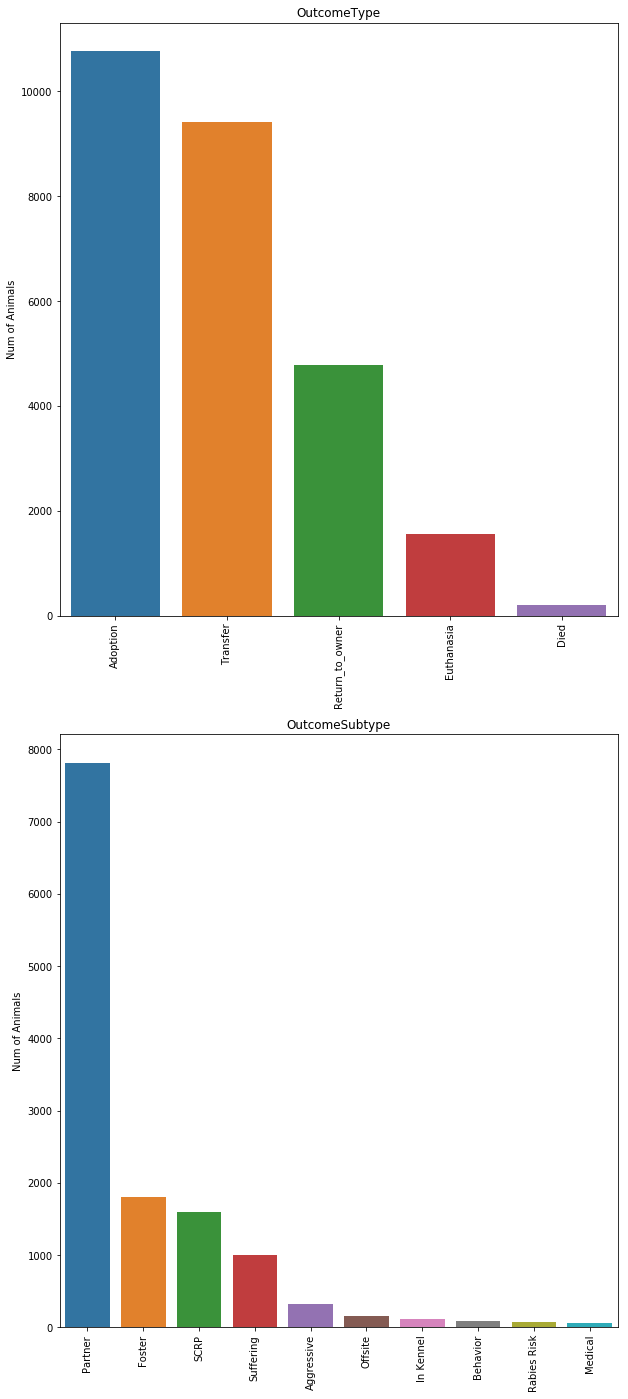

In [6]:
# Obtain headers.
headers = train_df.dtypes.index

# Categorical headers of classes.
cat_headers = ['OutcomeType', 'OutcomeSubtype']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=train_df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

Overall, we see a large imbalance between the outcome classes, which we will discuss further below in our modeling section. The outcomes lean heavily toward Adoption, Transfer, and Return to Owner. There is a smaller, but notable, portion of Euthanasia outcomes, and a very small number of Died outcomes. Partner, which we see below is within the Transfer outcome, is the most common subtype; this presumably means that the animal was transferred to a partner organization or shelter.

While the `Outcome Subtype` variable is also missing for many animals, we do not need to predict based on this variable, so this does not pose a problem for feature evaluation. We cannot use the outcome subtype as a feature, as it would bias the dataset. However, we do want to investigate outcome subtype more fully in an effort to understand the data.

In [7]:
train_df.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

OutcomeType       OutcomeSubtype  Count
0     Adoption                 Barn      1
1     Adoption               Foster   1800
2     Adoption              Offsite    165
3         Died               At Vet      4
4         Died              Enroute      8
5         Died            In Foster     52
6         Died            In Kennel    114
7         Died           In Surgery      3
8   Euthanasia           Aggressive    320
9   Euthanasia             Behavior     86
10  Euthanasia  Court/Investigation      6
11  Euthanasia              Medical     66
12  Euthanasia          Rabies Risk     74
13  Euthanasia            Suffering   1002
14    Transfer                 Barn      1
15    Transfer              Partner   7816
16    Transfer                 SCRP   1599

In exploring `Outcome Subtype`, we note a large quantity of null values in the `Adoption` outcome. The only subtypes labeled in this category are `Foster`, `Offsite`, and in one case, `Barn`. We feel an important next step is to dig further into the null data. 

Key `Outcome Subtype` definitions are:
- SCRP = Stray Cat Return Program, a catch-and-release program to spay/neuter stray cats (https://www.maddiesfund.org/austin-animal-services-stray-cat-return-program.htm)
- Barn = Barn Cat Program, which places cats from euthanasia lists that "cannot be adopted as traditional pets" into safe, appropriate adoption environments, such as a barn, stable, garage, or warehouse. They have access to shelter, food, and water. (https://www.austinpetsalive.org/ - https://www.austinpetsalive.org/about/programs/barn-cat-placements/)

In [8]:
train_df_sub = train_df[train_df['OutcomeSubtype'].isnull()]
train_df_sub.head()

AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0   A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
8   A671784     Lucy  2014-02-04 17:17:00         Adoption            NaN   
11  A666320      NaN  2013-11-04 14:48:00         Adoption            NaN   
13  A704702  Scooter  2015-06-08 16:30:00  Return_to_owner            NaN   
14  A688584  Preston  2015-11-25 15:00:00  Return_to_owner            NaN   

   AnimalType SexuponOutcome AgeuponOutcome                          Breed  \
0         Dog  Neutered Male         1 year          Shetland Sheepdog Mix   
8         Dog  Spayed Female       5 months  American Pit Bull Terrier Mix   
11        Dog  Spayed Female        2 years        Miniature Schnauzer Mix   
13        Dog  Neutered Male        2 years          Yorkshire Terrier Mix   
14        Dog  Neutered Male         1 year             Great Pyrenees Mix   

          Color  
0   Brown/White  
8     Red/White  
11       Silver  
13    Black/Red  
14  White/Cream

From the data in the table above, we surmise that it is possible the majority of the subtype null data is from the `Return to Owner` or `Adoption` outcome type data. We will examine this further below.

In [9]:
train_df_sub_2 = train_df_sub['OutcomeType'].value_counts().reset_index(
    name='Count of Null')
train_df_sub_2.rename(index=str, columns={"index": "Outcome Types"})

Outcome Types  Count of Null
0         Adoption           8803
1  Return_to_owner           4786
2             Died             16
3         Transfer              6
4       Euthanasia              1

8,803 of the Adoption outcome entries have the outcome subtype as `null`. As we already have outcome subtypes for barn, foster, and offsite within adoption, we feel confident in assuming that these missing subtypes are simply the animals that were adopted. We will assume this is true and fill these null values with `adopted`.

As the return-to-owner outcome type also has no subtype, we will make the outcome subtype `return to owner`. It seems that, within the dataset, when the outcome subtype would have been redundant with the outcome type, the outcome subtype was not always listed. Logically, once an animal is adopted or returned to their owner, a shelter feels it does not need further classification or follow up on specific outcomes.

For the remaining 23 null outcome subtypes, we will label their subtype as `other`.

In [10]:
def subtype(x):
    if x['OutcomeType'] == 'Adoption' and pd.isnull(
        x['OutcomeSubtype']) : return 'Adopted'
    elif x['OutcomeType'] == 'Return_to_owner' and pd.isnull(
        x['OutcomeSubtype']): return 'Return to Owner'
    elif pd.isnull(x['OutcomeSubtype']) : return 'Other'
    else: return x['OutcomeSubtype']

train_df['OutcomeSubtype'] = train_df.apply(subtype, axis=1)

In [11]:
train_df.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

OutcomeType       OutcomeSubtype  Count
0          Adoption              Adopted   8803
1          Adoption                 Barn      1
2          Adoption               Foster   1800
3          Adoption              Offsite    165
4              Died               At Vet      4
5              Died              Enroute      8
6              Died            In Foster     52
7              Died            In Kennel    114
8              Died           In Surgery      3
9              Died                Other     16
10       Euthanasia           Aggressive    320
11       Euthanasia             Behavior     86
12       Euthanasia  Court/Investigation      6
13       Euthanasia              Medical     66
14       Euthanasia                Other      1
15       Euthanasia          Rabies Risk     74
16       Euthanasia            Suffering   1002
17  Return_to_owner      Return to Owner   4786
18         Transfer                 Barn      1
19         Transfer                Other      6
20         Transfer              Partner   7816
21         Transfer                 SCRP   1599

## Feature Review

Following the class review, we will now review the specific features themselves. We begin by performing a graphic review of the distribution of values among features in the training set. 

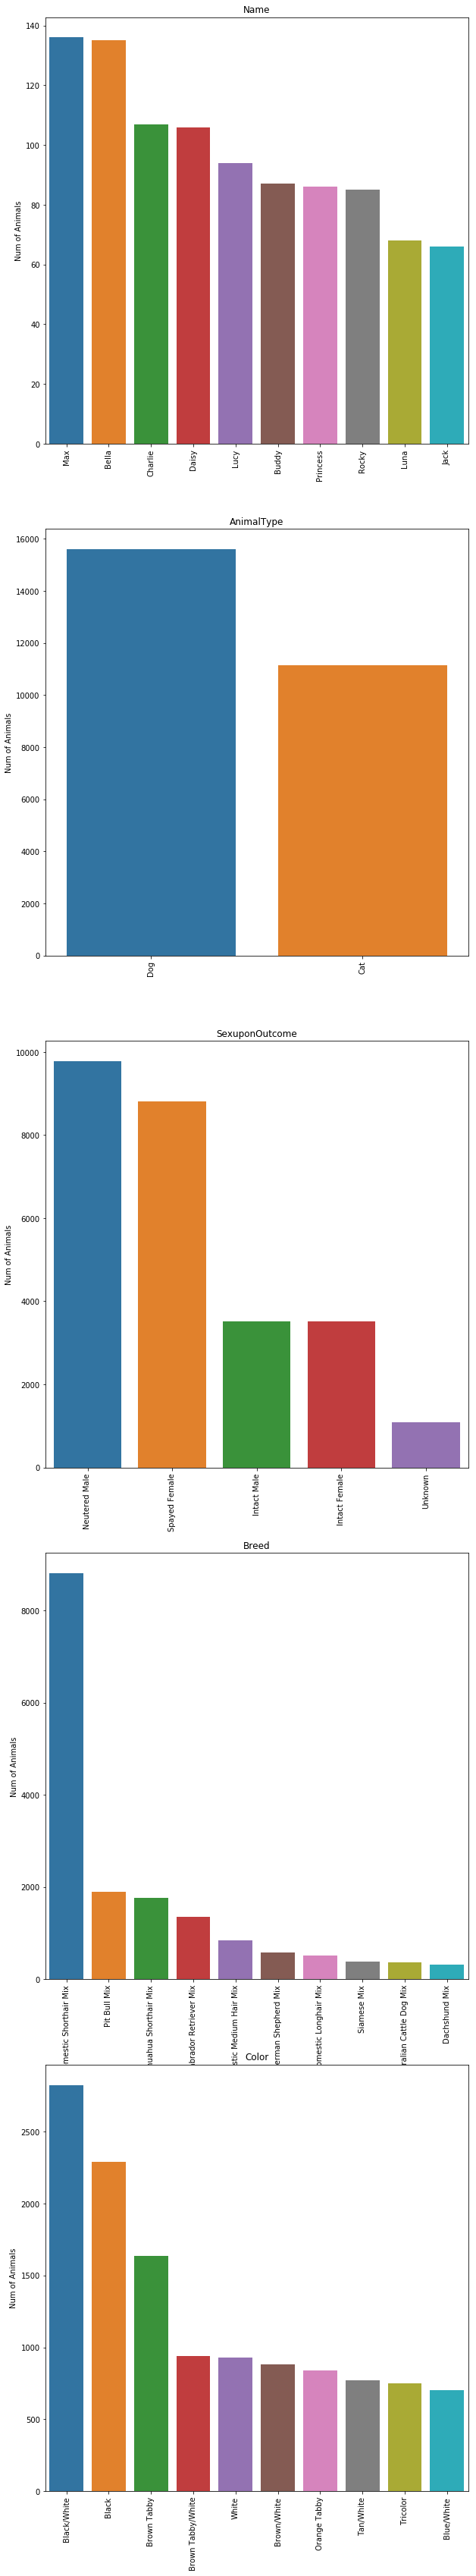

In [12]:
# Obtain headers.
headers = train_df.dtypes.index

# Not all of these are categorical variables.  
# We need categorical headers and continuous headers, with two different 
# types of plots.

# Categorical headers of features.
cat_headers = ['Name', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=train_df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

A breakdown of `Animal Type` shows that there are only dogs and cats in the dataset, with dogs accounting for about 60% of cases.

Sex Upon Outcome shows us whether the animal is male or female and whether they were spayed or neutered (fixed) prior to the outcome. There is a roughly even split between male and female animals, an overwhelming majority of which were spayed or neutered upon outcome. There are also a small, but notable, quantity of unknowns. We will look further below at this variable's interaction with animal outcomes.

The Breed feature is dominated by domestic shorthair cats, which is a catch-all breed label and by far the most common type of cat. There are nearly 9,000 of these. No other breed exceeds 2,000. The most common dog breed is Pitbull Mix.

The most common color is Black/White, followed closely by Black. Taken together as predominantly black, these two colors would substantially outweigh any others. Brown Tabby and Brown Tabby/White are the next most common colors, which is interesting, as these are colors that are only attributable to cats. Black/White and Black could be either dogs or cats. The other top colors are evenly distributed.

In [13]:
train_df_sex_dropna = train_df.dropna(subset=['SexuponOutcome'])
train_df_sex_outcome = train_df_sex_dropna.groupby(
    ['OutcomeType', 'SexuponOutcome']).agg({'AnimalType':'size'}).rename(
    columns={'AnimalType':'# of Animals'}).reset_index()
train_df_sex_outcome

OutcomeType SexuponOutcome  # of Animals
0          Adoption  Intact Female           203
1          Adoption    Intact Male           158
2          Adoption  Neutered Male          5222
3          Adoption  Spayed Female          5186
4              Died  Intact Female            56
5              Died    Intact Male            79
6              Died  Neutered Male            19
7              Died  Spayed Female            18
8              Died        Unknown            25
9        Euthanasia  Intact Female           401
10       Euthanasia    Intact Male           477
11       Euthanasia  Neutered Male           344
12       Euthanasia  Spayed Female           232
13       Euthanasia        Unknown           101
14  Return_to_owner  Intact Female           301
15  Return_to_owner    Intact Male           477
16  Return_to_owner  Neutered Male          2247
17  Return_to_owner  Spayed Female          1748
18  Return_to_owner        Unknown            12
19         Transfer  Intact Female          2550
20         Transfer    Intact Male          2334
21         Transfer  Neutered Male          1947
22         Transfer  Spayed Female          1636
23         Transfer        Unknown           955

Examining the distribution of sexes per outcome illuminates the story better than the earlier graphic representation. More than 10,000 of the adopted animals were spayed or neutered upon adoption. Only 361 were not. Of the animals that were returned to owners, a large majority had also been spayed or neutered. Among the other category, spayed/neutered/male/female were all evenly distributed. Most of the unknowns are seen in the transfer outcome. We will look to binarize gender and whether an animal was fixed for our analysis below.

Next, we look into the Age Upon Outcome feature variable. We believed that it is important to make the ages variable continuous, as opposed to categorical, as the relationship of age is continuous in nature. The most logical unit to standardize ages is weeks. Most of the ages are given in weeks, months, or years, all of which easily transform to weeks. Several ages are given in days, but all are 6 days or fewer. We will standardize these as zero weeks so that they are on the same scale as the rest of the data.

In [14]:
# Map all AgeuponOutcome values to numbers. Mapped to weeks and rounded to the 
# nearest week.
train_df['AgeuponOutcome'] = train_df[
    'AgeuponOutcome'].map({'1 week': 1, '1 weeks': 1, '2 weeks': 2, '3 weeks': 3,
                           '4 weeks': 4, '5 weeks': 5, '1 month': 4, '2 months': 9,
                           '3 months': 13, '4 months': 17, '5 months': 21, 
                           '6 months': 26, '7 months': 30, '8 months': 34, 
                           '9 months': 38, '10 months': 43, '11 months': 47, 
                           '1 year': 52, '2 years': 204, '3 years': 156,
                           '4 years': 208, '5 years': 260, '6 years': 312, 
                           '7 years': 364, '8 years': 416, '9 years': 468, 
                           '10 years': 520, '11 years': 572, '12 years': 624, 
                           '13 years': 676, '14 years': 728, '15 years': 780, 
                           '16 years': 832, '17 years': 884, '18 years': 936, 
                           '20 years': 1040, '0 years': 26, '1 day': 0, '2 days': 0,
                           '3 days': 0, '4 days': 0, '5 days': 0, '6 days': 0})

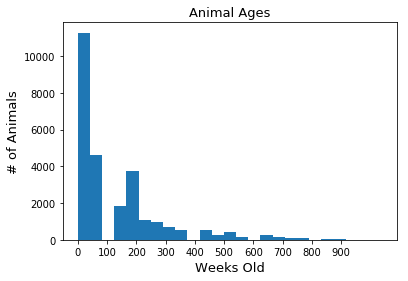

In [15]:
train_df_age_dropna = train_df.dropna(subset=['AgeuponOutcome'])

plt.hist(train_df_age_dropna['AgeuponOutcome'], bins = 25) 

plt.title("Animal Ages")
plt.xlabel("Weeks Old")
plt.ylabel("# of Animals")
plt.xticks(np.arange(0, 1000, step=100))

# Font size transformations.
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(13)

plt.grid(False)

A substantial portion of the animals in the dataset reached their outcomes at under one year of age (52 weeks). We see sizable numbers of outcomes up to the four-year mark (208 weeks). After four years of age, outcomes drop precipitously.

In [16]:
train_df_age_dropna_2 = train_df_age_dropna[(
    train_df_age_dropna.AgeuponOutcome <= 104)]
train_df_age_dropna_3 = train_df_age_dropna[(
    train_df_age_dropna.AgeuponOutcome <= 156)]
print("Examining the ages of younger animals further, ", round(
    (train_df_age_dropna_2.shape[0] / train_df_age_dropna.shape[0])*100,2), 
      "% of animals are under the age of two years old and ", 
      round((train_df_age_dropna_3.shape[0] / train_df_age_dropna.shape[0])*100,2),
     "% are under the age of three years old.", sep="")

Examining the ages of younger animals further, 59.38% of animals are under the age of two years old and 66.2% are under the age of three years old.


In [17]:
train_df_age_outcome = train_df_age_dropna.groupby(
    'OutcomeType').agg({'AnimalType':'size', 
                        'AgeuponOutcome':'mean'}).rename(
    columns={'AnimalType':'# of Animals', 
             'AgeuponOutcome':'Avg. Age Upon Outcome (in Wk)'}).reset_index()
print("Avg. Age of Animals Upon Outcome:", (round(
    train_df_age_dropna.AgeuponOutcome.mean())), "weeks")

train_df_age_outcome.round(1)

Avg. Age of Animals Upon Outcome: 127 weeks


OutcomeType  # of Animals  Avg. Age Upon Outcome (in Wk)
0         Adoption         10769                           97.7
1             Died           197                           79.3
2       Euthanasia          1551                          223.2
3  Return_to_owner          4785                          233.7
4         Transfer          9406                           91.7

From the information above, we can see that a more likely outcome for younger animals is to be transfered or adopted, while older animals are more likely to be returned to their owner or euthanized. While the `Died` outcome has the lowest average age upon outcome, only 0.7% of animals fall into this category. Therefore, we can assume that many of these animals were unhealthy upon birth and died young.

The age variable is explicitly defined as the age upon outcome; we do not know the ages of animals when they entered shelters. We also do not know how long animals were at the shelter prior to their outcome, and we have no insights into animals still in shelters.

Next, we will look at the `DateTime` column to understand a little more about trends over time in the dataset. We will assume that the `DateTime column` references when the outcome of each animal was determined. We will evaluate this information over time by week to group the data.

In [18]:
# Convert our DateTime column to the proper format and then group by week.
train_df['DateTime'] = pd.to_datetime(
    train_df['DateTime']) - pd.to_timedelta(7, unit='d')
train_df_time = train_df.groupby([pd.Grouper(
    key='DateTime', freq='W-SUN')]).size().reset_index().sort_values('DateTime')
train_df_time.columns = ['DateTime', 'All']

# Filter for the specific outcome types so that we can later look at the differences 
# by outcome type.
headers = ['Adoption', 'Transfer', 'Return_to_owner', 'Euthanasia', 'Died']
for Outcome in headers:
    train_df_outcome = train_df[train_df.OutcomeType == Outcome].groupby(
        [pd.Grouper(key='DateTime', freq='W-SUN')]).size(
    ).reset_index().sort_values('DateTime')
    train_df_time = pd.merge(
        train_df_time, train_df_outcome, on='DateTime', how='outer')

# Rename the columns to represent each outcome header.
train_df_time.columns = ['DateTime', 'All', 'Adoption', 'Transfer', 
                         'Return_to_owner', 'Euthanasia', 'Died']

train_df_time

DateTime  All  Adoption  Transfer  Return_to_owner  Euthanasia  Died
0   2013-09-29  192        73        69               34          13     3
1   2013-10-06  250       111        91               32          14     2
2   2013-10-13  239        71       110               41          16     1
3   2013-10-20  189        69        72               26          17     5
4   2013-10-27  201        97        58               29          16     1
5   2013-11-03  200        78        74               36          10     2
6   2013-11-10  195        75        69               38          13     0
7   2013-11-17  160        66        53               30          11     0
8   2013-11-24  187        85        57               32          12     1
9   2013-12-01  191        77        70               24          20     0
10  2013-12-08  189        81        59               36          12     1
11  2013-12-15  246       110        79               46          11     0
12  2013-12-22  212       115        60               21          16     0
13  2013-12-29  216        96        60               48          10     2
14  2014-01-05  164        65        50               35          14     0
15  2014-01-12  178        70        58               41           9     0
16  2014-01-19  155        70        54               19          11     1
17  2014-01-26  150        70        41               30           8     1
18  2014-02-02  159        56        55               39           7     2
19  2014-02-09  160        62        53               30          15     0
20  2014-02-16  165        67        57               35           6     0
21  2014-02-23  161        59        55               31          14     2
22  2014-03-02  169        67        63               29          10     0
23  2014-03-09  171        53        68               38          11     1
24  2014-03-16  196        67        66               50          13     0
25  2014-03-23  190        71        62               36          18     3
26  2014-03-30  204        73        66               51          13     1
27  2014-04-06  161        61        54               38           7     1
28  2014-04-13  231        66       104               47          14     0
29  2014-04-20  188        53        89               36           9     1
..         ...  ...       ...       ...              ...         ...   ...
95  2015-07-26  245       112        91               26          15     1
96  2015-08-02  212        79        80               39          11     3
97  2015-08-09  259       109        95               34          17     4
98  2015-08-16  206        95        73               32           5     1
99  2015-08-23  276       119       105               42           7     3
100 2015-08-30  250        99       102               36          11     2
101 2015-09-06  268       117        95               42          13     1
102 2015-09-13  240        85       106               36          11     2
103 2015-09-20  202        91        79               25           6     1
104 2015-09-27  178        63        65               39           8     3
105 2015-10-04  255        80       117               46           6     6
106 2015-10-11  233       115        67               37          10     4
107 2015-10-18  200        77        75               39           9     0
108 2015-10-25  228        68        91               61           6     2
109 2015-11-01  220        82        64               59          11     4
110 2015-11-08  261       104        82               64           8     3
111 2015-11-15  207        97        69               40           0     1
112 2015-11-22  216       108        54               47           6     1
113 2015-11-29  189        77        59               42          10     1
114 2015-12-06  188       103        38               43           3     1
115 2015-12-13  212       114        58               38           2     0
116 2015-12-20  189        88  

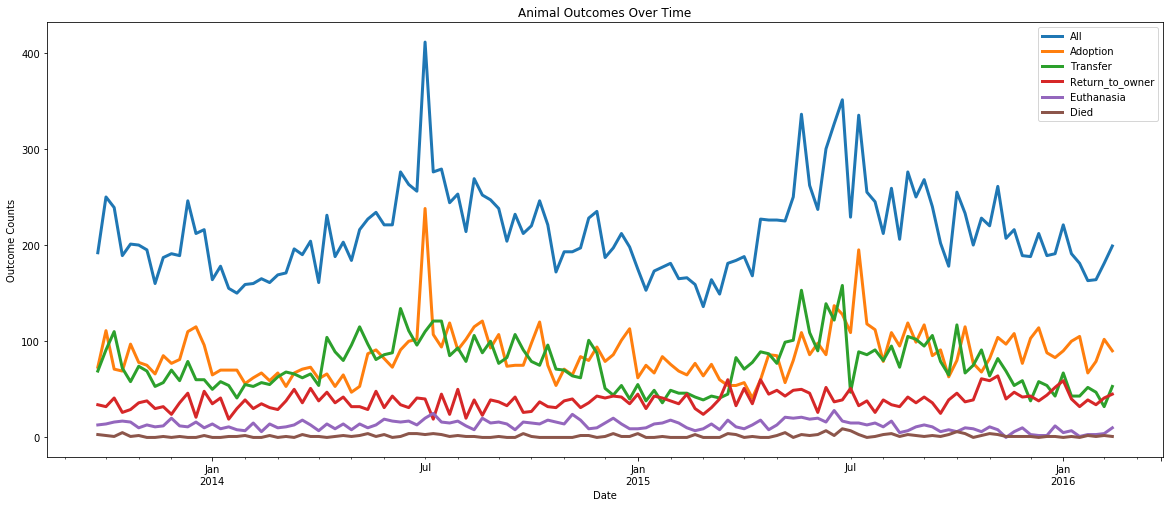

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = train_df_time.iloc[: , 1:].plot(
    ax = ax, x=train_df_time['DateTime'], sort_columns=True, linewidth=3.0)

plt.xlabel('Date')
plt.ylabel('Outcome Counts')
plt.title('Animal Outcomes Over Time')
ax.legend()
plt.show()

From the `DateTime` analysis, we are able to evaluate animal outcomes from Oct 2014 through Feb 2016. We see that most animals are adopted in the summertime, around July and August. Adoption outcomes spike a bit during this time period as well; however, all other outcomes are evenly distributed throughout the time period of analysis.

# Feature Manipulation and Binarization

## Combining Features

Before binarizing features, we thought doing some simple feature selection could be a good first start. As the breed type has over 1,000 variations and color has over 300 variations, we will see if combining any like features could make sense.

In [20]:
# Evaluate the Breed feature set for combination.
train_df_breed_list = train_df['Breed'].tolist()
train_df_breed_dict = {i:train_df_breed_list.count(i) for i in set(
    train_df_breed_list)}

print("Number of unique breeds within the dataset:", train_df['Breed'].describe()[1])

# Analyze the different combinations of breeds.
for k in sorted(train_df_breed_dict): 
    print(k,": ",train_df_breed_dict[k], sep="", end=", ")

Number of unique breeds within the dataset: 1380
Abyssinian Mix: 2, Affenpinscher Mix: 6, Afghan Hound Mix: 1, Airedale Terrier: 1, Airedale Terrier Mix: 5, Airedale Terrier/Labrador Retriever: 1, Airedale Terrier/Miniature Schnauzer: 1, Akita: 3, Akita Mix: 11, Akita/Australian Cattle Dog: 1, Akita/Chow Chow: 1, Akita/German Shepherd: 1, Akita/Labrador Retriever: 1, Akita/Pit Bull: 1, Akita/Siberian Husky: 2, Alaskan Husky: 2, Alaskan Husky Mix: 10, Alaskan Husky/Australian Shepherd: 2, Alaskan Husky/Border Collie: 1, Alaskan Husky/German Shepherd: 1, Alaskan Malamute: 1, Alaskan Malamute Mix: 5, Alaskan Malamute/Akita: 1, Alaskan Malamute/Australian Kelpie: 1, Alaskan Malamute/Border Collie: 2, Alaskan Malamute/German Shepherd: 1, American Bulldog: 6, American Bulldog Mix: 109, American Bulldog/American Staffordshire Terrier: 1, American Bulldog/Chinese Sharpei: 1, American Bulldog/Great Pyrenees: 1, American Bulldog/Labrador Retriever: 3, American Bulldog/Mastiff: 2, American Bulldo

In [21]:
# Remove the secondary breed name.
def split_breed(x):
    if '/' in x['Breed'] : return x['Breed'].split('/', 1)[1]
    else : return x['Breed']
    
train_df['Breed'] = train_df.apply(split_breed, axis=1)

In [22]:
# Remove the word "mix" from the breed type.
train_df['Breed'] = train_df['Breed'].str.replace(' Mix', '')

In [23]:
print("We have taken the unique number of breeds from 1,380 to", 
      train_df['Breed'].describe()[1], "by removing the secondary breed type",
      "and the word \"mix\".")

We have taken the unique number of breeds from 1,380 to 225 by removing the secondary breed type and the word "mix".


In [24]:
# Evaluate the Color feature set for combination.
train_df_color_list = train_df['Color'].tolist()
train_df_color_dict = {i:train_df_color_list.count(i) for i in set(train_df_color_list)}

print("Number of unique colors within the dataset:", train_df['Color'].describe()[1])

# Analyzing the different combinations of colors.
for k in sorted(train_df_color_dict):
    print(k,": ",train_df_color_dict[k], sep="", end=", ")

Number of unique colors within the dataset: 366
Agouti: 1, Agouti/Brown Tabby: 1, Apricot: 21, Apricot/Brown: 2, Apricot/White: 3, Black: 2292, Black Brindle: 20, Black Brindle/Black: 1, Black Brindle/Brown: 3, Black Brindle/Brown Brindle: 1, Black Brindle/White: 74, Black Smoke: 46, Black Smoke/Brown Tabby: 1, Black Smoke/White: 15, Black Tabby: 42, Black Tabby/Orange: 1, Black Tabby/White: 18, Black Tiger/White: 2, Black/Black: 4, Black/Black Brindle: 5, Black/Black Smoke: 3, Black/Black Tabby: 1, Black/Blue: 3, Black/Blue Merle: 8, Black/Blue Tick: 6, Black/Brown: 436, Black/Brown Brindle: 45, Black/Brown Merle: 2, Black/Buff: 5, Black/Chocolate: 2, Black/Cream: 10, Black/Gray: 38, Black/Orange: 3, Black/Red: 17, Black/Silver: 3, Black/Silver Tabby: 1, Black/Tan: 672, Black/Tricolor: 39, Black/White: 2824, Black/Yellow: 1, Black/Yellow Brindle: 2, Blue: 450, Blue Cream: 11, Blue Cream/Blue Tabby: 1, Blue Cream/Blue Tiger: 1, Blue Cream/Buff: 1, Blue Cream/Tortie: 1, Blue Cream/White

In [25]:
# Remove the secondary color name to focus on the principal color.
def split_color(x):
    if '/' in x['Color'] : return x['Color'].split('/', 1)[1]
    else : return x['Color']
    
train_df['Color'] = train_df.apply(split_color, axis=1)

In [26]:
print("We have taken the unique number of colors from 366 to", 
      train_df['Color'].describe()[1], "by focusing on the primary color",
      "\nand removing the secondary color.")

We have taken the unique number of colors from 366 to 55 by focusing on the primary color 
and removing the secondary color.


Moving forward, we are focusing on primary breed and color, working under the assumption that someone adopting an animal is likely to focus on the predominant feature in each of these categories. When a potential adopter sees border collie mix or border collie/labrador retriever, they are likely to process this as "border collie" first and foremost. Colors work the same way: the difference between calico vs. calico/white is negligible. 

The remaining colors could be reduced further, as they mix colors and coat types (blue vs. blue tabby), but we determined that these were unique enough to keep separate in a single field.

## Train Data Transformations and Binarization

In order to transform our dataset and make it ready for model evaluation, we are going to create dummy variables for all of our continuous variables and binarize all of our features. For our age variable, we are going to normalize all of the data, as the variable is continuous.

In [27]:
train_df_binarize = train_df.copy()
train_df_binarize.head()

AnimalID     Name            DateTime      OutcomeType   OutcomeSubtype  \
0  A671945  Hambone 2014-02-05 18:22:00  Return_to_owner  Return to Owner   
1  A656520    Emily 2013-10-06 12:44:00       Euthanasia        Suffering   
2  A686464   Pearce 2015-01-24 12:28:00         Adoption           Foster   
3  A683430      NaN 2014-07-04 19:09:00         Transfer          Partner   
4  A667013      NaN 2013-11-08 12:52:00         Transfer          Partner   

  AnimalType SexuponOutcome  AgeuponOutcome               Breed        Color  
0        Dog  Neutered Male            52.0   Shetland Sheepdog        White  
1        Cat  Spayed Female            52.0  Domestic Shorthair  Cream Tabby  
2        Dog  Neutered Male           204.0            Pit Bull        White  
3        Cat    Intact Male             3.0  Domestic Shorthair   Blue Cream  
4        Dog  Neutered Male           204.0    Miniature Poodle          Tan

In [28]:
# Split SexuponOutcome into dummy variables, so that both will only have two options.
train_df_binarize['State'], train_df_binarize['Gender'] = train_df_binarize[
    'SexuponOutcome'].str.split(' ', 1).str

train_df_binarize['State'] = train_df_binarize['State'].map({'Neutered': 'Fixed', 
                                                             'Spayed': 'Fixed', 
                                                             'Intact': 'Intact'})

In [29]:
# Pick the column(s) to binarize.
train_df_binarize_animaltype = pd.get_dummies(train_df_binarize['AnimalType'])
train_df_binarize_state = pd.get_dummies(train_df_binarize['State'])
train_df_binarize_gender = pd.get_dummies(train_df_binarize['Gender'])

# Only keep one, as we only have two variables.
train_df_binarize_animaltype = train_df_binarize_animaltype['Dog']
train_df_binarize_state = train_df_binarize_state['Fixed']
train_df_binarize_gender = train_df_binarize_gender['Male']

# Combine the state binarization and the original dataset.
train_df_binarize = pd.concat([train_df_binarize, train_df_binarize_animaltype, train_df_binarize_state, train_df_binarize_gender], axis=1)

# Change the name of the columns that we just concatenated.
train_df_binarize = train_df_binarize.rename(index=str, columns={'Dog': 'AnimalType_Binarize(Dog=1)', 
                                                                 'Fixed': 'State(Fixed=1)', 
                                                                 'Male': 'Gender(Male=1)'})

In [30]:
# Pick the column(s) to binarize.
train_df_binarize_breed = pd.get_dummies(train_df_binarize['Breed'])
train_df_binarize_color = pd.get_dummies(train_df_binarize['Color'])

# Need to keep all of the columns, as we have more than two breeds.
# Combine the breed binarization and the original dataset.
train_df_binarize = pd.concat([train_df_binarize, train_df_binarize_breed, train_df_binarize_color], axis=1)

In [31]:
# Normalize age upon outcome.
train_df_binarize['AgeuponOutcome_norm'] = train_df_binarize['AgeuponOutcome']/max(train_df_binarize['AgeuponOutcome'])

In [32]:
# Fill NaN values with the median value for the column.
train_df_binarize['AgeuponOutcome_norm'].fillna(train_df_binarize['AgeuponOutcome_norm'].median(), inplace=True)

As discussed above, we decided not to binarize the `Name` variable, as the dataset has over 6,000 unique names. With just over 26,700 rows in the dataset, and names only present in just over 19,000, we believed that the dataset would be too sparse if we created a unique column for each name. The sparsity would lead to the names likely not being very good features in predicting animal outcomes.

In [33]:
# Print full list of columns from binarization to check work.
print("Num of columns:", len(list(train_df_binarize.columns.values)), 
      "\nand columns:", list(train_df_binarize.columns.values),end="")

Num of columns: 296 
and columns: ['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'State', 'Gender', 'AnimalType_Binarize(Dog=1)', 'State(Fixed=1)', 'Gender(Male=1)', 'Abyssinian', 'Affenpinscher', 'Afghan Hound', 'Airedale Terrier', 'Akita', 'Alaskan Husky', 'Alaskan Malamute', 'American Bulldog', 'American Eskimo', 'American Foxhound', 'American Pit Bull Terrier', 'American Shorthair', 'American Staffordshire Terrier', 'Anatol Shepherd', 'Angora', 'Australian Cattle Dog', 'Australian Kelpie', 'Australian Shepherd', 'Australian Terrier', 'Balinese', 'Basenji', 'Basset Hound', 'Beagle', 'Bearded Collie', 'Beauceron', 'Bedlington Terr', 'Belgian Malinois', 'Belgian Sheepdog', 'Belgian Tervuren', 'Bengal', 'Bernese Mountain Dog', 'Bichon Frise', 'Black Mouth Cur', 'Black/Tan Hound', 'Bloodhound', 'Blue Lacy', 'Bluetick Hound', 'Boerboel', 'Bombay', 'Border Collie', 'Border Terrier', 'Borzoi', 'Boston Te

In [34]:
# Check sparsity of the training set.
print("Sparsity of the binarized training set:", '%.2f'%(100*((
    np.product(train_df_binarize.shape) - np.count_nonzero(
        train_df_binarize))/np.product(train_df_binarize.shape))),"%")

Sparsity of the binarized training set: 94.34 %


Despite the feature consolidation, the binarization resulted in a very sparse data set.

In [35]:
# Export a CSV record of the dataset.
train_df_binarize.to_csv('data/train_df_binarization.csv')

## Test Data Transformations and Binarization

Our features have to be consistent between the training and test datasets for prediction purposes. Therefore, we are making the same feature transformations and binarizations of our test dataset.

In [36]:
test_df_binarize = test_df.copy()
test_df_binarize.head()

ID      Name             DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer  2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne  2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus  2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo  2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter  2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color  
0          Labrador Retriever Mix    Red/White  
1  German Shepherd/Siberian Husky    Black/Tan  
2          Domestic Shorthair Mix  Brown Tabby  
3               Collie Smooth Mix     Tricolor  
4            Miniature Poodle Mix        White

In [37]:
# Split SexuponOutcome into variables, so that both will only have two options 
# as we did for the training dataset.
test_df_binarize['State'], test_df_binarize['Gender'] = test_df_binarize[
    'SexuponOutcome'].str.split(' ', 1).str

test_df_binarize['State'] = test_df_binarize['State'].map({'Neutered': 'Fixed', 
                                                             'Spayed': 'Fixed', 
                                                             'Intact': 'Intact'})
test_df_binarize.head()

ID      Name             DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer  2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne  2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus  2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo  2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter  2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color   State  Gender  
0          Labrador Retriever Mix    Red/White  Intact  Female  
1  German Shepherd/Siberian Husky    Black/Tan   Fixed  Female  
2          Domestic Shorthair Mix  Brown Tabby   Fixed    Male  
3               Collie Smooth Mix     Tricolor  Intact    Male  
4            Miniature Poodle Mix        White   Fixed    Male

In [38]:
# Map all AgeuponOutcome values to numbers as we did in the test dataset. Mapped to 
# weeks and rounded to the nearest week.
test_df_binarize[
    'AgeuponOutcome'] = test_df_binarize[
    'AgeuponOutcome'].map({'1 week': 1, '1 weeks': 1, '2 weeks': 2,
                           '3 weeks': 3, '4 weeks': 4, '5 weeks': 5, 
                           '1 month': 4, '2 months': 9, '3 months': 13, 
                           '4 months': 17, '5 months': 21, '6 months': 26, 
                           '7 months': 30, '8 months': 34, '9 months': 38, 
                           '10 months': 43, '11 months': 47, '1 year': 52, 
                           '2 years': 204, '3 years': 156, '4 years': 208, 
                           '5 years': 260, '6 years': 312, '7 years': 364,
                           '8 years': 416, '9 years': 468, '10 years': 520, 
                           '11 years': 572, '12 years': 624, '13 years': 676,
                           '14 years': 728, '15 years': 780, '16 years': 832,
                           '17 years': 884, '18 years': 936, '20 years': 1040,
                           '0 years': 26, '1 day': 0, '2 days': 0, '3 days': 0,
                           '4 days': 0, '5 days': 0, '6 days': 0})

In [39]:
# Change breed types that we changed in train to accurately match test.
# Remove the secondary breed name.
def split_breed(x):
    if '/' in x['Breed'] : return x['Breed'].split('/', 1)[1]
    else : return x['Breed']
    
test_df_binarize['Breed'] = test_df_binarize.apply(split_breed, axis=1)

In [40]:
# Remove the word "mix" from the breed type.
test_df_binarize['Breed'] = test_df_binarize['Breed'].str.replace(' Mix', '')

In [41]:
# Remove the secondary color name to focus on principal color as we did in 
# training set.
def split_color(x):
    if '/' in x['Color'] : return x['Color'].split('/', 1)[1]
    else : return x['Color']
    
test_df_binarize['Color'] = test_df_binarize.apply(split_color, axis=1)

In [42]:
# Pick the column(s) to binarize.
test_df_binarize_animaltype = pd.get_dummies(test_df_binarize['AnimalType'])
test_df_binarize_state = pd.get_dummies(test_df_binarize['State'])
test_df_binarize_gender = pd.get_dummies(test_df_binarize['Gender'])

# Only keep one, as we only have two variables.
test_df_binarize_animaltype = test_df_binarize_animaltype['Dog']
test_df_binarize_state = test_df_binarize_state['Fixed']
test_df_binarize_gender = test_df_binarize_gender['Male']

# Combine the state binarization and the original dataset.
test_df_binarize = pd.concat([test_df_binarize, 
                              test_df_binarize_animaltype, test_df_binarize_state, 
                              test_df_binarize_gender], axis=1)

# Change the name of the columns that we just concatenated.
test_df_binarize = test_df_binarize.rename(
    index=str, columns={'Dog': 'AnimalType_Binarize(Dog=1)', 
                        'Fixed': 'State(Fixed=1)', 'Male': 'Gender(Male=1)'})

In [43]:
# Pick the column(s) to binarize.
test_df_binarize_breed = pd.get_dummies(test_df_binarize['Breed'])
test_df_binarize_color = pd.get_dummies(test_df_binarize['Color'])

# Need to keep all of the columns, as we have more than two breeds.
# Combine the breed binarization and the original dataset.
test_df_binarize = pd.concat([
    test_df_binarize, test_df_binarize_breed, test_df_binarize_color], axis=1)

# Normalize age upon outcome on training set maximium.
test_df_binarize['AgeuponOutcome_norm'] = test_df_binarize[
    'AgeuponOutcome']/max(train_df_binarize['AgeuponOutcome'])
test_df_binarize['AgeuponOutcome_norm'].fillna(test_df_binarize[
    'AgeuponOutcome_norm'].median(), inplace=True)

In [44]:
test_df_binarize.head()

ID      Name             DateTime AnimalType SexuponOutcome  \
0   1    Summer  2015-10-12 12:15:00        Dog  Intact Female   
1   2  Cheyenne  2014-07-26 17:59:00        Dog  Spayed Female   
2   3       Gus  2016-01-13 12:20:00        Cat  Neutered Male   
3   4     Pongo  2013-12-28 18:12:00        Dog    Intact Male   
4   5   Skooter  2015-09-24 17:59:00        Dog  Neutered Male   

   AgeuponOutcome               Breed        Color   State  Gender  \
0            43.0  Labrador Retriever        White  Intact  Female   
1           204.0      Siberian Husky          Tan   Fixed  Female   
2            52.0  Domestic Shorthair  Brown Tabby   Fixed    Male   
3            17.0       Collie Smooth     Tricolor  Intact    Male   
4           204.0    Miniature Poodle        White   Fixed    Male   

          ...           Silver Tabby  Tan  Torbie  Tortie  Tortie Point  \
0         ...                      0    0       0       0             0   
1         ...                      0    1       0       0             0   
2         ...                      0    0       0       0             0   
3         ...                      0    0       0       0             0   
4         ...                      0    0       0       0             0   

   Tricolor  White  Yellow  Yellow Brindle  AgeuponOutcome_norm  
0         0      1       0               0             0.041346  
1         0      0       0               0             0.196154  
2         0      0       0               0             0.050000  
3         1      0       0               0             0.016346  
4         0      1       0               0             0.196154  

[5 rows x 270 columns]

In [45]:
test_df_binarize.rename(columns = {'ID':'AnimalID'}, inplace = True)

In [46]:
# Print full list of columns from binarization to check work
print("Num of columns:", len(list(test_df_binarize.columns.values)), 
      "\nand columns:", list(test_df_binarize.columns.values),end="")

Num of columns: 270 
and columns: ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'State', 'Gender', 'AnimalType_Binarize(Dog=1)', 'State(Fixed=1)', 'Gender(Male=1)', 'Abyssinian', 'Airedale Terrier', 'Akita', 'Alaskan Husky', 'Alaskan Malamute', 'American Bulldog', 'American Eskimo', 'American Foxhound', 'American Pit Bull Terrier', 'American Shorthair', 'American Staffordshire Terrier', 'American Wirehair', 'Anatol Shepherd', 'Angora', 'Australian Cattle Dog', 'Australian Kelpie', 'Australian Shepherd', 'Australian Terrier', 'Balinese', 'Basenji', 'Basset Hound', 'Beagle', 'Bearded Collie', 'Beauceron', 'Belgian Malinois', 'Belgian Tervuren', 'Bengal', 'Bernese Mountain Dog', 'Bichon Frise', 'Black Mouth Cur', 'Black/Tan Hound', 'Bloodhound', 'Blue Lacy', 'Bluetick Hound', 'Boerboel', 'Bombay', 'Border Collie', 'Border Terrier', 'Boston Terrier', 'Boxer', 'Boykin Span', 'British Shorthair', 'Brittany', 'Bruss Griffon', 'Bull Terrie

In [47]:
# Examine the unique columns in train_df_binarize and test_df_binarize.
# We will eventually want all columns in training to also be accounted for in test.
x = set(train_df_binarize.columns).symmetric_difference(test_df_binarize.columns)

# Parse out only the unique items in both lists within the training list and 
# test list, respectively.
train_unique = [value for value in list(x) 
                if value in list(train_df_binarize.columns.values)]
test_unique = [value for value in list(x) 
               if value in list(test_df_binarize.columns.values)]

print ("Number of unique columns in the train dataset not \
       present in the test dataset:", len(train_unique))
print ("Number of unique columns in the test dataset not present \
       in the train dataset:", len(test_unique))

Number of unique columns in the train dataset not present in the test dataset: 42
Number of unique columns in the test dataset not present in the train dataset: 16


We will rectify the issue of the training and test datasets not having the same number of features by adding features initialized with zero to the test dataset. We will also remove features exclusive to the test dataset.

In [48]:
# Add all of the unique columns in the training dataset to the test dataset and 
# initialize as 0.
for col in train_unique:
    test_df_binarize[col] = 0
    
print ("New number of columns in the test binarization dataset \
       adding train only columns:", len(list(test_df_binarize.columns.values)))

New number of columns in the test binarization dataset adding train only columns: 312


In [49]:
# Remove all of the unique columns in the test dataset that are not also in 
# the training dataset.
test_df_binarize = test_df_binarize.drop([col for col in test_unique], axis=1)

print ("New number of columns in the test binarization dataset \
       removing test only columns:", 
       len(list(test_df_binarize.columns.values)))

New number of columns in the test binarization dataset removing test only columns: 296


In [50]:
# Export a CSV record of the dataset.
test_df_binarize.to_csv('data/test_df_binarization.csv')

# Literature Review

Next, we looked at our literature. From our EDA, we realized that we had hundreds of features, even after reduction, many of which were the very sparse dummy variables for breed and color. We also realized that we had very unbalanced classes, which would make prediction difficult with some algorithms, given that our test dataset would likely not have the same balance as our training dataset. From our class readings and algorithm review, we thought random forests may be our best bet, so we began our literature investigation there.
 
Many of our papers discussed the relative merits of using logistic regression or random forest classifiers. One particular article, dealing with storm data, taught us about two performance scores that may work even better than receiver operating characteristic curves for highly unbalanced data: false alarm rate and threat score, (Ruiz, Anne, and Villa, Nathalie). Other papers discussed the benefits of the random forest procedure over a single decision tree classifier. Especially for applications in which there are a large number of features, but not all observations have all of the features, random forests win out over individual decision trees, (Breiman, Leo).
 
Other articles helped us learn more about decision trees and random forests holistically. For instance, we were able to understand more about the advantages and disadvantages between tree complexity and the goodness of fit, which would be helpful for our models as well, (Song, Yan-yan, and Lu, Ying). We also learned that, while the weight of feature importance varies within each tree, order of feature importance usually does not. Therefore, random forests can likely provide us with good outcomes, (Liaw, Andy and Wiener, Matthew).
 
With regards to the potential data imputation process, we read about the merits of oversampling and undersampling. For instance, we opted to oversample from our underrepresented outcome classes and undersample from our overrepresented outcome classes to try and balance the data for better predictions (Galar, M., A. Fernandez, E. Barrenechea, H. Bustince, and F. Herrera).

# Setting up data for model building

In [51]:
# Reorder the test data columns to be in the same order as the train data columns.

train_cols = train_df_binarize.columns.tolist()
test_df_binarize_ordered = test_df_binarize[train_cols]

In [52]:
# We need to separate the training data and labels and add them to a pandas dataframe.
train_data_pd = train_df_binarize.iloc[: , 13:]
train_labels_pd = train_df_binarize['OutcomeType']

train_data_pd.head()

State(Fixed=1)  Gender(Male=1)  Abyssinian  Affenpinscher  Afghan Hound  \
0               1               1           0              0             0   
1               1               0           0              0             0   
2               1               1           0              0             0   
3               0               1           0              0             0   
4               1               1           0              0             0   

   Airedale Terrier  Akita  Alaskan Husky  Alaskan Malamute  American Bulldog  \
0                 0      0              0                 0                 0   
1                 0      0              0                 0                 0   
2                 0      0              0                 0                 0   
3                 0      0              0                 0                 0   
4                 0      0              0                 0                 0   

          ...           Silver Tabby  Tan  Torbie  Tortie  Tortie Point  \
0         ...                      0    0       0       0             0   
1         ...                      0    0       0       0             0   
2         ...                      0    0       0       0             0   
3         ...                      0    0       0       0             0   
4         ...                      0    1       0       0             0   

   Tricolor  White  Yellow  Yellow Brindle  AgeuponOutcome_norm  
0         0      1       0               0             0.050000  
1         0      0       0               0             0.050000  
2         0      1       0               0             0.196154  
3         0      0       0               0             0.002885  
4         0      0       0               0             0.196154  

[5 rows x 283 columns]

Within our model building process, we will first turn our binarized train and test data frames into numpy arrays for efficiency. We will also remove our outcome variable from the training dataset and create a separate label array.

In [53]:
# We need a numpy array to run the models efficiently, so we convert the 
# training data here.
train_data = train_data_pd.values
train_data

array([[1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.05      ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05      ],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.19615385],
       ...,
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.2       ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.00384615],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.05      ]])

In [54]:
# We need a numpy array to run the models efficiently, so we convert the training 
# labels here.
train_labels = train_labels_pd.values
train_labels

array(['Return_to_owner', 'Euthanasia', 'Adoption', ..., 'Adoption',
       'Transfer', 'Transfer'], dtype=object)

In [55]:
# We need to separate the test data and add it to a pandas dataframe.
test_data_pd = test_df_binarize_ordered.iloc[: , 13:]

test_data_pd.head()

State(Fixed=1)  Gender(Male=1)  Abyssinian  Affenpinscher  Afghan Hound  \
0               0               0           0              0             0   
1               1               0           0              0             0   
2               1               1           0              0             0   
3               0               1           0              0             0   
4               1               1           0              0             0   

   Airedale Terrier  Akita  Alaskan Husky  Alaskan Malamute  American Bulldog  \
0                 0      0              0                 0                 0   
1                 0      0              0                 0                 0   
2                 0      0              0                 0                 0   
3                 0      0              0                 0                 0   
4                 0      0              0                 0                 0   

          ...           Silver Tabby  Tan  Torbie  Tortie  Tortie Point  \
0         ...                      0    0       0       0             0   
1         ...                      0    1       0       0             0   
2         ...                      0    0       0       0             0   
3         ...                      0    0       0       0             0   
4         ...                      0    0       0       0             0   

   Tricolor  White  Yellow  Yellow Brindle  AgeuponOutcome_norm  
0         0      1       0               0             0.041346  
1         0      0       0               0             0.196154  
2         0      0       0               0             0.050000  
3         1      0       0               0             0.016346  
4         0      1       0               0             0.196154  

[5 rows x 283 columns]

In [56]:
# We need a numpy array to run the models efficiently, so we convert the test 
# data here.
test_data = test_data_pd.values
test_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04134615],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19615385],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.05      ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05      ],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.3       ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.2       ]])

In [57]:
# Check train_data and train_labels shape.
print('train_data shape:', train_data.shape, 
      '\ntrain_labels shape:', train_labels.shape,
      '\ntest_data shape:', test_data.shape
     )

train_data shape: (26729, 283) 
train_labels shape: (26729,) 
test_data shape: (11456, 283)


# Model Creation

## Baseline model - the "Dumb" classifier

If we were to fit a model that predicted that all outcomes were the majority class, we would get a classification report seen below. This model is not a good one, but this will be the baseline against which we test our performance and accuracy improvements. We will evaluate all of our models below using the f1-score. We decided that accuracy, which is simply the proportion of observations predicted correctly over total observations, is not the best measure. Accuracy assigns equal weight to false positives and false negatives. When the dataset is balanced, that can work very well. However, as we discovered earlier, our dataset is not balanced. Therefore, we would still have mediocre accuracy if all observations were predicted as the adoption class (which we will see below).

We will use the weighted f1-score to evaluate prediction performance. The weighted f1-score takes a proportional weight of the f1-score of all classes to calculate the weighted f1-score. The f1-score itself takes precision (ratio of the true positives to true and false positives) and recall (ratio of the true positives to true positives and false negatives) into account. Therefore, the f1-score is essentially taking both false positives and false negatives into account without needing to weight them equally. This type of scoring system to evaluate prediction performance works best when classes are not balanced.

In [58]:
# Set all predicted values to "Adoption".
pred_labels = train_labels.copy()
pred_labels.fill('Adoption')
print(classification_report(train_labels, pred_labels))
print('Accuracy = {:.2f}'.format(np.mean(train_labels == pred_labels)))
f1_dict = {}
f1_dict['Dumb'] = ['%0.2f' % metrics.f1_score(
    train_labels, pred_labels, average='micro'),
                   '%0.2f' % metrics.f1_score(
                       train_labels, pred_labels, average='weighted'), '']

                 precision    recall  f1-score   support

       Adoption       0.40      1.00      0.57     10769
           Died       0.00      0.00      0.00       197
     Euthanasia       0.00      0.00      0.00      1555
Return_to_owner       0.00      0.00      0.00      4786
       Transfer       0.00      0.00      0.00      9422

      micro avg       0.40      0.40      0.40     26729
      macro avg       0.08      0.20      0.11     26729
   weighted avg       0.16      0.40      0.23     26729

Accuracy = 0.40


If we had a model that predicted just adoption, we would have an accuracy of 0.40, and a weighted f1-score of 0.23.  

## Finding and Choosing the Best Algorithm

In order to decide which algorithm to use, we need to test several approaches. Our first step is to create a function, using the `StratifiedKFold` library within sckit-learn, to split our training dataset into training and test. This function randomly splits the training and test data (for our purposes, development data) a specified number of times. Therefore, we do not need to create a separate development dataset. We will be optimizing the weighted f1-score utilizing the StratifiedKFold function.

The StratifiedKFold trains the classifiers on about 90% of the training data and then predicts on 10% of the training data. We decided to pick the StratifiedKFold function over the KFold function, as the StratifiedKFold function picks a proportional distribution, while the KFold function simply selects from the distribution. As our classes were so unbalanced, we believed that the StratifiedKFold function would give us a more representative sampling. 

We decided to first start with five separate predictions to check if the accuracy changed each time with logistic regression, decision trees, random forests. Since we are working with a sparse data set, we researched additional classifiers that might perform well with that constraint. The only recommendation we found with which we were not familar was XGboost, which builds upon the decision tree approach with a gradient-boosted decision trees method. Gradient boosting constructs new decision tree models that predict the residuals of prior models and then adds them together to make final predictions. It uses a gradient descent algorithm to minimize loss when adding in new models (Chen, Tianqi and Guestrin, Carlos). While this algorithm is fast compared to other gradient boosted tree classifiers, it is extraordinarily slow compared to the other methods we are using. However, it usually does well with large-scale datasets. 

We will print classification reports at each stage to understand more about each algorithm, as well as other performance measures. Along with the StratifiedKFold function, we also set up functions to ensure that we are printing classification reports and confusion matrices where necessary. Lastly, we will implement a function to check the variance between each of the training and test datasets.

Since our dataset contains labels, we are steering away from unsupervised clustering approaches, such as K Means and Gaussian Mixture models, and focusing on supervised approaches.

In [59]:
def print_matrix(cm, title):
    '''This function takes in a confusion matrix, and plots it.'''
    n = cm.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap = 'Blues')
    plt.title('Confusion Matrix, {}'.format(title))
    fig.colorbar(cax)
    plt.xticks(np.arange(0, n, step=1))
    plt.yticks(np.arange(0, n, step=1))
    for x in range(n):
        for y in range(n):
            plt.text(x,y,str(cm[y][x]), horizontalalignment='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return fig

In [60]:
def stratfit(clf, train_data, train_labels, n_splits=10):
    '''This function fits train_data and train_labels to any 
    classifier using StratifiedKFold. It prints a classification report, 
    a confusion matrix.'''

    # Use StratifiedKFold here so that we can preserve the relative percentage 
    # of classes in the folds.
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(train_data) 

    # For the stratifiedkfolds, fit the classifier, 
    # predict values and generate a classifier report for the training folds,
    # then predict values and generate a classifier report for the test folds.
    for index, [train_index, test_index] in enumerate(kf.split(train_data, 
                                                               train_labels)):
        print("\nTRAIN:", len(train_index), "and TEST:", len(test_index))
        
        # Fit the model to the training folds.
        clf_out = clf.fit(train_data[train_index], train_labels[train_index])
        
        # Predict values for the training folds.
        pred_labels_train = clf.predict(train_data[train_index])
        
        # Print the classification report.
        print('\nFor train data:\n', 
              classification_report(train_labels[train_index], pred_labels_train))
        
        # Predict values for the test folds.
        pred_labels = clf.predict(train_data[test_index])
        
        # Print classification report.
        print('For test data:\n', 
              classification_report(train_labels[test_index], pred_labels))
        
        # Print the confusion matrix.
        print_matrix(confusion_matrix(train_labels[test_index], 
                                      pred_labels), 'Split {}'.format(index + 1))
        
        # Add weighted accuracy and f1 scores to temporary lists.
        accuracy_temp_list.append(metrics.f1_score(train_labels[test_index], 
                                                   pred_labels, average='micro'))
        f1_temp_list.append(metrics.f1_score(train_labels[test_index], 
                                             pred_labels, average='weighted'))

In [61]:
def check_variance(clf, X_train, y_train, n_splits=100):
    '''This function takes in a classifier (clf), data (X_train), labels (y_train),
    repeatedly fits the classifier to a stratified cross validation set, 
    and returns the weighted f1_scores. Will use this function throughout.
    '''
    # Create shufflesplit that will split into n_splits folds, and put 20 % 
    # into the test
    cv = ShuffleSplit(n_splits=n_splits, test_size = 0.2)
    # Caclulate f1 score for each fit, and store it in cv_scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')
       
    return cv_scores

In [62]:
# Initiate dictionary to hold cv_scores for each kind of classifier.
cv_scores_dict = {}

In [63]:
# Initiate lists to hold accuracy and f1 scores while StratifiedKFold is calculating. 
f1_temp_list = []
accuracy_temp_list = []

We start with logistic regression as the first attempted classifier, as we are familiar with it.


TRAIN: 21381 and TEST: 5348

For train data:
                  precision    recall  f1-score   support

       Adoption       0.62      0.89      0.73      8615
           Died       0.00      0.00      0.00       157
     Euthanasia       0.51      0.03      0.05      1244
Return_to_owner       0.47      0.29      0.36      3828
       Transfer       0.73      0.62      0.67      7537

      micro avg       0.63      0.63      0.63     21381
      macro avg       0.47      0.37      0.36     21381
   weighted avg       0.62      0.63      0.60     21381

For test data:
                  precision    recall  f1-score   support

       Adoption       0.61      0.89      0.72      2154
           Died       0.00      0.00      0.00        40
     Euthanasia       0.39      0.02      0.04       311
Return_to_owner       0.47      0.29      0.36       958
       Transfer       0.72      0.61      0.66      1885

      micro avg       0.63      0.63      0.63      5348
      macro avg     

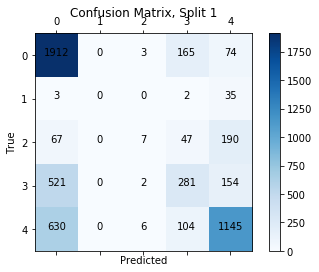

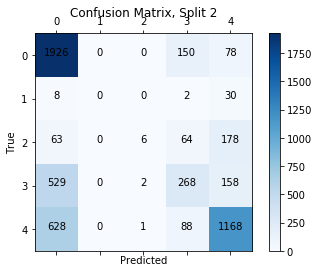

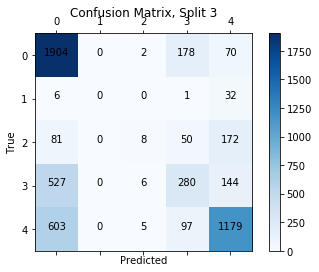

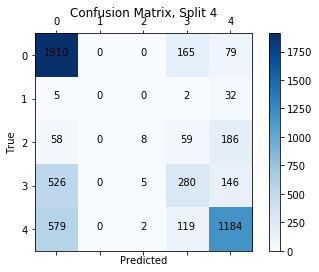

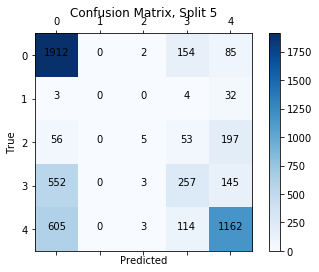

In [64]:
clf_LR = LogisticRegression()
stratfit(clf_LR, train_data, train_labels, n_splits=5)
cv_scores_dict[
    '1. Logistic Regression\nwith Raw Data'] = check_variance(
    clf_LR, train_data, train_labels, n_splits = 5)
f1_dict['Logistic Regression with Raw Data'] = [
    '%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

Our weighted f1-score is ~0.59 for the logistic regression classifier for test data.  While this is an improvement over the base case, we think we can find a classifier that is better.  

Next, let's evaluate a decision tree classifier.

In [1]:
clf_DT = DecisionTreeClassifier()
stratfit(clf_DT, train_data, train_labels, n_splits = 5)
cv_scores_dict['2. Decision Tree\nwith Raw Data'] = check_variance(clf_DT
                                                                   , train_data
                                                                   , train_labels
                                                                   , n_splits = 5
                                                                  )
f1_dict['Decision Tree with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

NameError: name 'DecisionTreeClassifier' is not defined

Our weighted f1-score on the test folds is ~0.58 for the decision tree classifier.  This is slightly worse than the logistic regression classifier. 

We also note that the f1-score for the test data (folds that were reserved for testing) is much lower than the training data (folds that were used for training), so we can say we have definitely poorly generalized the data for the decision tree classifier. The generalization problem points to the fact that the algorithm is not good at learning unseen data, as the prediction for the training data was far better than the prediction for the test data. We could counter the poor generalization problem by limiting the max_depth of the decision tree and setting a min_samples_split to be higher than the default of 2. 

Next, we try the random forest classifier. We expect this to perform better than the decision tree out of the box, as this classifier takes the average of multiple decision trees, but we also think we will be able to tune it in order to get great performance in the end.


TRAIN: 21381 and TEST: 5348

For train data:
                  precision    recall  f1-score   support

       Adoption       0.77      0.89      0.83      8615
           Died       0.82      0.25      0.39       157
     Euthanasia       0.78      0.47      0.59      1244
Return_to_owner       0.75      0.65      0.70      3828
       Transfer       0.82      0.80      0.81      7537

      micro avg       0.78      0.78      0.78     21381
      macro avg       0.79      0.61      0.66     21381
   weighted avg       0.79      0.78      0.78     21381

For test data:
                  precision    recall  f1-score   support

       Adoption       0.64      0.75      0.69      2154
           Died       0.00      0.00      0.00        40
     Euthanasia       0.22      0.12      0.15       311
Return_to_owner       0.43      0.36      0.39       958
       Transfer       0.66      0.64      0.65      1885

      micro avg       0.60      0.60      0.60      5348
      macro avg     

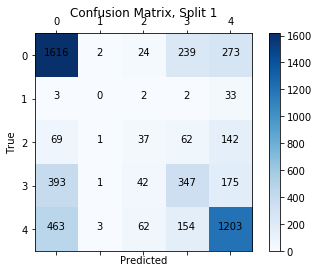

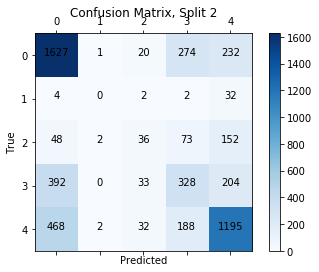

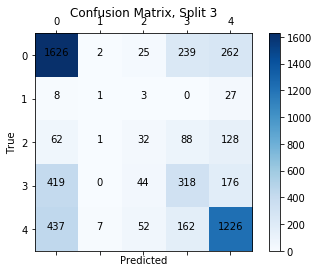

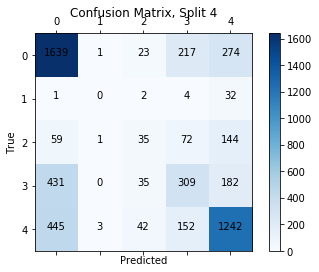

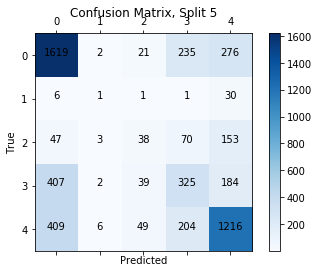

In [66]:
clf_RF = RandomForestClassifier()
stratfit(clf_RF, train_data, train_labels, n_splits=5)
cv_scores_dict['3. Random Forest\nwith Raw Data'] = check_variance(clf_RF
                                                                   , train_data
                                                                   , train_labels
                                                                   , n_splits = 5
                                                                  )
f1_dict['Random Forest with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

Our weighted f1-score is ~0.58 for the random forest classifier. This is in line with the decision tree classifier and slightly worse than the logistic regression classifier. 

As we see with decision trees, the f1-scores for the test data (folds that were reserved for testing) is much lower than the train data (folds that were used for training), so we can say we have poorly generalized the data for the random forest classifier. We can counter the poor generalization problem by limiting the max_depth of the random forest and setting a min_samples_split to be higher than the default of 2. We will do this in the `GridSearch` during the optimization step.

Next, we will try out the XGBoost classifier.


TRAIN: 21381 and TEST: 5348

For train data:
                  precision    recall  f1-score   support

       Adoption       0.63      0.87      0.73      8615
           Died       0.00      0.00      0.00       157
     Euthanasia       0.60      0.07      0.13      1244
Return_to_owner       0.47      0.39      0.43      3828
       Transfer       0.76      0.61      0.68      7537

      micro avg       0.64      0.64      0.64     21381
      macro avg       0.49      0.39      0.39     21381
   weighted avg       0.64      0.64      0.62     21381

For test data:
                  precision    recall  f1-score   support

       Adoption       0.61      0.86      0.72      2154
           Died       0.00      0.00      0.00        40
     Euthanasia       0.60      0.08      0.15       311
Return_to_owner       0.43      0.35      0.39       958
       Transfer       0.75      0.60      0.67      1885

      micro avg       0.63      0.63      0.63      5348
      macro avg     

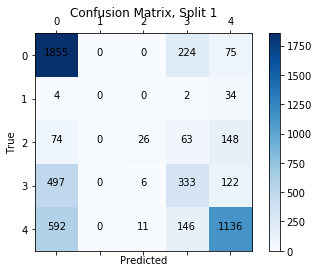

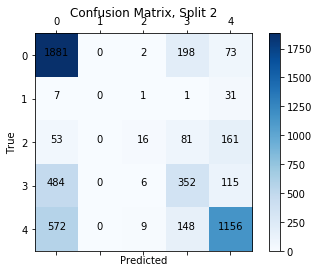

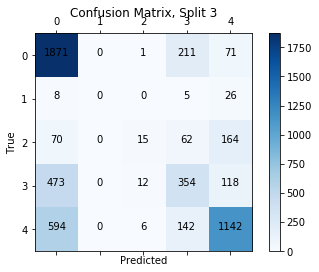

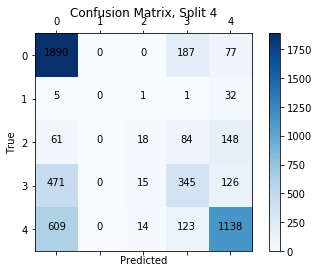

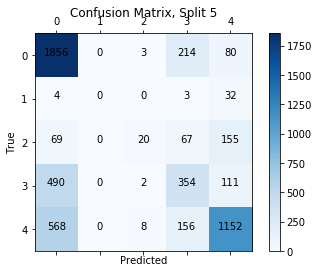

In [67]:
clf_XGB = xgb.XGBClassifier()
stratfit(clf_XGB, train_data, train_labels, n_splits=5)
cv_scores_dict['4. XGBoost\nwith Raw Data'] = check_variance(clf_XGB
                                                                   , train_data
                                                                   , train_labels
                                                                   , n_splits = 5
                                                                  )
f1_dict['XGBoost with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

Though XGBoost runs very slowly, it returned a weighted f1-score is ~0.61, which is slightly better than all other outcomes thus far. This result tells us that XGBoost is worth further study.

We will examine logistic regression, random forests, and XGBoost as we refine our parameters and features. We will not continue with individual decision trees.

Throughout all of our analysis, the weighted f1-score was very consistent through each StratifiedKFold split, but the generalization issue highlighted our aforementioned data imbalance concerns with some of our outcome classes. We believe that if we work to over or under sample, we might be able to help our algorithm generalize to unseen data. The variance between each f1-score within each model was not large, as all f1-scores were close to each other within each classifier, so we are not incredibly worried about overfitting. However, we will perform further cross-validation between the test folds to evaluate our specific amount of overfitting.

## Correcting for Class Imbalance

Since our data is so imbalanced, and we observe very few deaths and euthanasia outcomes, our models predict these outcomes quite poorly. We attempt to deal with this via oversampling then undersampling.

We used the RandomOverSampler() function to oversample from classes with low quantities of outcomes.

In [68]:
# Oversample to balance outcome classes.
ros = RandomOverSampler(random_state=0)
train_data_os, train_labels_os = ros.fit_resample(train_data, train_labels)

# Count to double check how many animals are in each class after we employ the RandomOverSampler.
print(sorted(Counter(train_labels_os).items()))

[('Adoption', 10769), ('Died', 10769), ('Euthanasia', 10769), ('Return_to_owner', 10769), ('Transfer', 10769)]


The result of this function is a near even amount of animals in each outcome class. Now that we have a balanced dataset, let's re-try the classifiers that we wanted to explore further: Logistic Regression, Random Forest, and XGBoost.


TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.52      0.72      0.60      8615
           Died       0.50      0.73      0.60      8615
     Euthanasia       0.53      0.37      0.44      8615
Return_to_owner       0.49      0.54      0.51      8615
       Transfer       0.50      0.16      0.24      8615

      micro avg       0.51      0.51      0.51     43075
      macro avg       0.51      0.51      0.48     43075
   weighted avg       0.51      0.51      0.48     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.51      0.71      0.60      2154
           Died       0.51      0.74      0.60      2154
     Euthanasia       0.52      0.37      0.43      2154
Return_to_owner       0.48      0.54      0.51      2154
       Transfer       0.51      0.15      0.23      2154

      micro avg       0.50      0.50      0.50     10770
      macro avg    

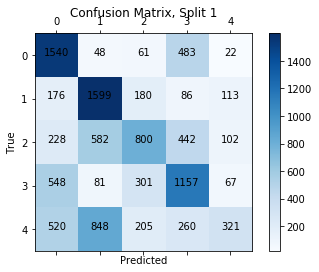

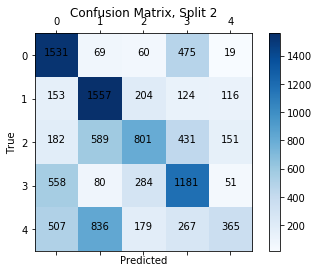

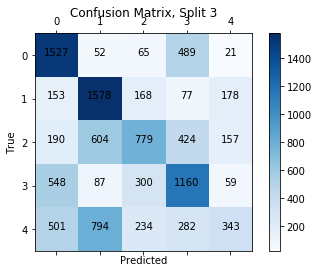

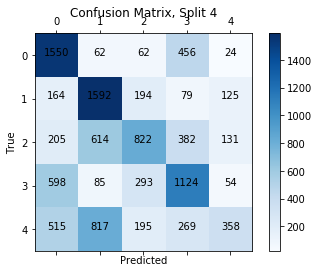

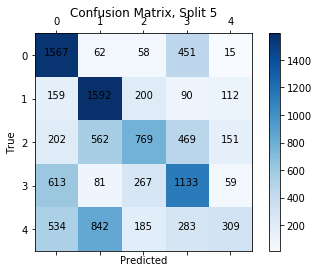

In [69]:
clf_LR = LogisticRegression()
stratfit(clf_LR, train_data_os, train_labels_os, n_splits=5)
cv_scores_dict['5. Logistic Regression\nwith Oversampled Data'] = check_variance(clf_LR
                                                                                 , train_data_os
                                                                                 , train_labels_os
                                                                                 , n_splits = 5
                                                                                )
f1_dict['Logistic Regression with Oversampled Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []


TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.80      0.75      0.78      8615
           Died       0.77      0.96      0.85      8615
     Euthanasia       0.73      0.76      0.75      8615
Return_to_owner       0.77      0.77      0.77      8615
       Transfer       0.79      0.59      0.68      8615

      micro avg       0.77      0.77      0.77     43075
      macro avg       0.77      0.77      0.76     43075
   weighted avg       0.77      0.77      0.76     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.68      0.62      0.65      2154
           Died       0.77      0.95      0.85      2154
     Euthanasia       0.71      0.75      0.73      2154
Return_to_owner       0.64      0.67      0.66      2154
       Transfer       0.67      0.50      0.57      2154

      micro avg       0.70      0.70      0.70     10770
      macro avg    

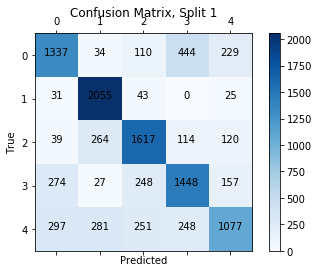

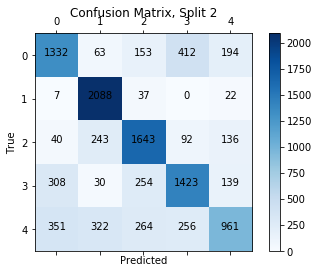

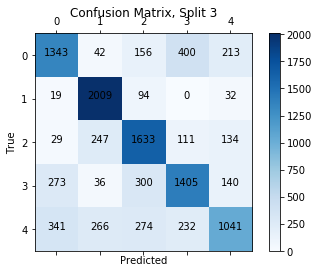

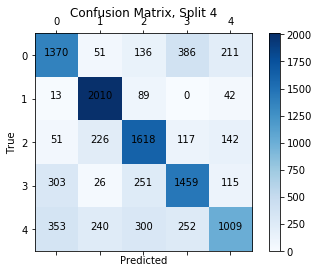

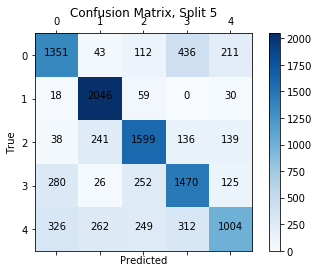

In [70]:
clf_RF = RandomForestClassifier()
stratfit(clf_RF, train_data_os, train_labels_os, n_splits=5)
cv_scores_dict['6. Random Forest\nwith Oversampled Data'] = check_variance(clf_RF
                                                                           , train_data_os
                                                                           , train_labels_os
                                                                           , n_splits = 5
                                                                          )
f1_dict['Random Forest with Oversampled Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []


TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.59      0.64      0.62      8615
           Died       0.62      0.68      0.65      8615
     Euthanasia       0.52      0.44      0.48      8615
Return_to_owner       0.46      0.61      0.52      8615
       Transfer       0.49      0.31      0.38      8615

      micro avg       0.54      0.54      0.54     43075
      macro avg       0.54      0.54      0.53     43075
   weighted avg       0.54      0.54      0.53     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.59      0.65      0.62      2154
           Died       0.61      0.68      0.64      2154
     Euthanasia       0.50      0.42      0.46      2154
Return_to_owner       0.46      0.60      0.52      2154
       Transfer       0.46      0.29      0.36      2154

      micro avg       0.53      0.53      0.53     10770
      macro avg    

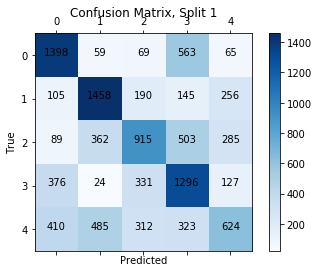

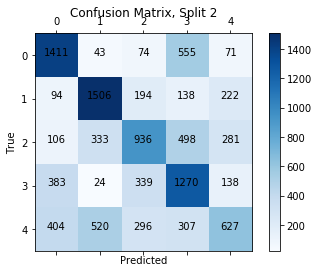

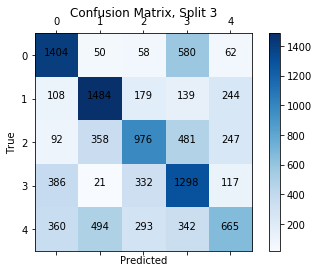

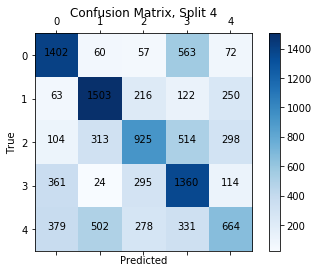

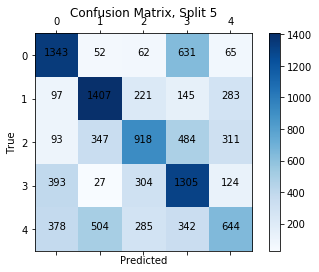

In [71]:
clf_XGB = xgb.XGBClassifier()
stratfit(clf_XGB, train_data_os, train_labels_os, n_splits=5)
cv_scores_dict['7. XGBoost\nwith Oversampled Data'] = check_variance(clf_XGB
                                                                           , train_data_os
                                                                           , train_labels_os
                                                                           , n_splits = 5
                                                                          )
f1_dict['XGBoost with Oversampled Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

Now, with the oversampled and balanced dataset, random forest returned a weighted f1-score of ~0.69 on the test folds, which is much better than before. We also see much better performance on died and euthanasia outcomes than with the unbalanced dataset. XGBoost performed substantially worse with the balanced dataset, returning a weighted f1-score of ~0.52. The logistic regression classifer also performed worse in this situation, returning a weighted f1-score of ~0.47. 

The random forest classifer f1-score on the balanced dataset is the best that we have seen so far. In addition, the f1-scores of the training data folds and test data folds were also closer together within the random forest classifier, showing a lesser amount of generalization with unseen data. Therefore, moving forward, we will look exclusively at optimizing the random forest classifier.

It is possible that other oversampling techniques may do better. Next, we try the `SMOTE` oversampler to see how that performs.

In [72]:
# Oversample to balance outcome classes.
ros = SMOTE(random_state=0)
train_data_os2, train_labels_os2 = ros.fit_resample(train_data, train_labels)

# Count to double check how many are in each class.
print(sorted(Counter(train_labels_os2).items()))

[('Adoption', 10769), ('Died', 10769), ('Euthanasia', 10769), ('Return_to_owner', 10769), ('Transfer', 10769)]



TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.79      0.82      0.80      8615
           Died       0.91      0.98      0.94      8615
     Euthanasia       0.84      0.86      0.85      8615
Return_to_owner       0.82      0.82      0.82      8615
       Transfer       0.82      0.70      0.76      8615

      micro avg       0.84      0.84      0.84     43075
      macro avg       0.84      0.84      0.84     43075
   weighted avg       0.84      0.84      0.84     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.63      0.68      0.65      2154
           Died       0.86      0.93      0.89      2154
     Euthanasia       0.69      0.69      0.69      2154
Return_to_owner       0.59      0.60      0.60      2154
       Transfer       0.61      0.51      0.56      2154

      micro avg       0.68      0.68      0.68     10770
      macro avg    

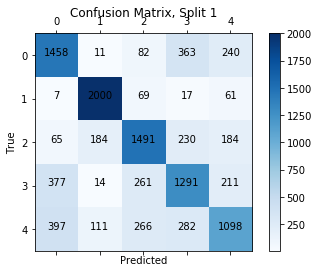

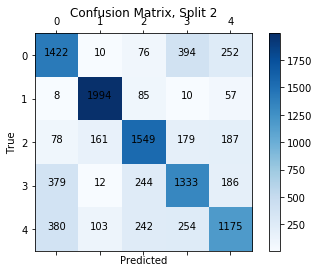

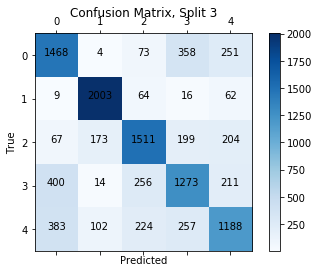

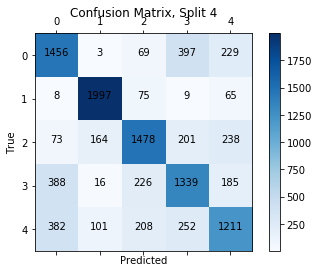

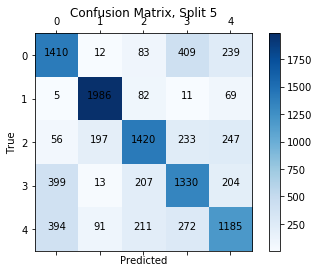

In [73]:
clf_RF = RandomForestClassifier()
stratfit(clf_RF, train_data_os2, train_labels_os2, n_splits=5)
f1_temp_list = []
accuracy_temp_list = []

It appears that the `SMOTE` oversampling technique not only takes a very long time to run, but also shows no performance improvements over the random oversampling case for the random forest classifier.

Next, we can perform a procedure of undersampling from the majority classes, just to see how well, or not, this performs. Undersampling takes the amount of examples present in the smallest class, and makes it so that each class can only have this many examples.

In [74]:
# Undersample to balance outcome classes.
rus = RandomUnderSampler(random_state=0)
train_data_us, train_labels_us = rus.fit_resample(train_data, train_labels)

print(sorted(Counter(train_labels_us).items()))

[('Adoption', 197), ('Died', 197), ('Euthanasia', 197), ('Return_to_owner', 197), ('Transfer', 197)]



TRAIN: 655 and TEST: 330

For train data:
                  precision    recall  f1-score   support

       Adoption       0.92      0.93      0.92       131
           Died       0.86      0.91      0.88       131
     Euthanasia       0.90      0.87      0.89       131
Return_to_owner       0.93      0.95      0.94       131
       Transfer       0.91      0.85      0.88       131

      micro avg       0.90      0.90      0.90       655
      macro avg       0.90      0.90      0.90       655
   weighted avg       0.90      0.90      0.90       655

For test data:
                  precision    recall  f1-score   support

       Adoption       0.44      0.47      0.45        66
           Died       0.43      0.48      0.45        66
     Euthanasia       0.43      0.41      0.42        66
Return_to_owner       0.32      0.38      0.34        66
       Transfer       0.21      0.14      0.17        66

      micro avg       0.38      0.38      0.38       330
      macro avg       0

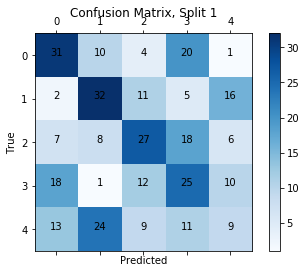

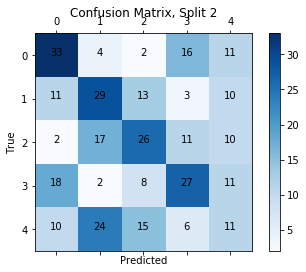

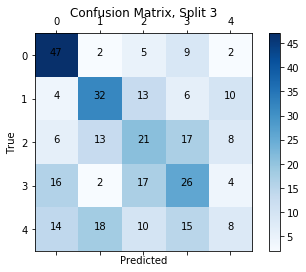

In [75]:
# Running RF again, with undersampling
clf_RF = RandomForestClassifier()
stratfit(clf_RF, train_data_us, train_labels_us, n_splits=3)
f1_dict['Random Forest with Undersampled Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

Not surprisingly, we saw a huge generalization problem within the undersampled dataset.  First, each class is limited to only 197 examples. The training folds also saw an almost perfect prediction with f1-scores at ~0.89, and test folds saw f1-scores of ~0.40. The training folds predicted very well, as there was so little data to learn, while the test folds did terribly, as the training data did not generalize well in such small quantities. We decided not to proceed with undersampling. Since random forest outperformed other classifiers by a substantial margin on the oversampled dataset, we opted to continue down the path of optimizing the performance of that approach.

Just to double check our intuition, we will test a Multinomial Naive Bayes classifier.  We expect it to perform poorly, especially for such a sparsely populated dataset. We thought about testing the k Nearest Neighbors classifier as well, but given the sparsity of our features and the number of observations, we felt this would be not be worthwhile.

Oversampled:

TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.54      0.18      0.27      8615
           Died       0.46      0.71      0.56      8615
     Euthanasia       0.51      0.19      0.28      8615
Return_to_owner       0.37      0.75      0.50      8615
       Transfer       0.26      0.18      0.21      8615

      micro avg       0.40      0.40      0.40     43075
      macro avg       0.43      0.40      0.36     43075
   weighted avg       0.43      0.40      0.36     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.49      0.16      0.24      2154
           Died       0.46      0.71      0.56      2154
     Euthanasia       0.50      0.20      0.29      2154
Return_to_owner       0.36      0.74      0.49      2154
       Transfer       0.25      0.18      0.21      2154

      micro avg       0.40      0.40      0.40     10770
      


For train data:
                  precision    recall  f1-score   support

       Adoption       0.55      0.64      0.59      8615
           Died       0.00      0.00      0.00       158
     Euthanasia       0.45      0.00      0.01      1244
Return_to_owner       0.40      0.39      0.40      3829
       Transfer       0.58      0.58      0.58      7538

      micro avg       0.53      0.53      0.53     21384
      macro avg       0.40      0.32      0.31     21384
   weighted avg       0.52      0.53      0.51     21384

For test data:
                  precision    recall  f1-score   support

       Adoption       0.53      0.64      0.58      2154
           Died       0.00      0.00      0.00        39
     Euthanasia       0.00      0.00      0.00       311
Return_to_owner       0.38      0.36      0.37       957
       Transfer       0.57      0.56      0.56      1884

      micro avg       0.52      0.52      0.52      5345
      macro avg       0.30      0.31      0.30   

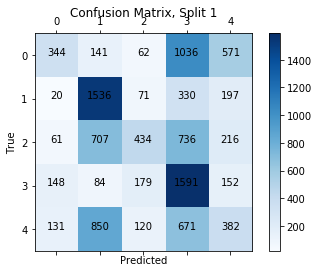

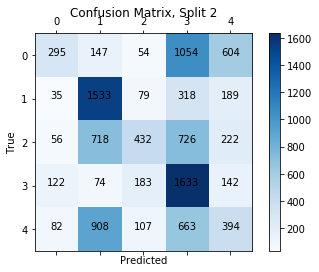

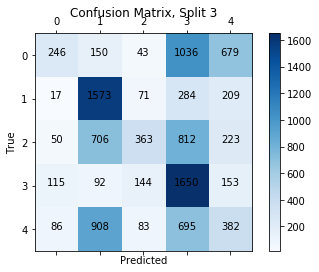

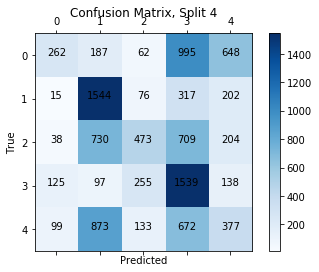

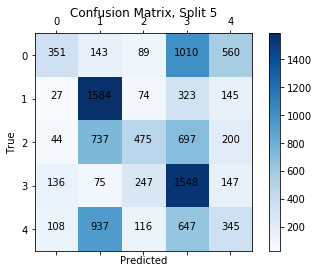

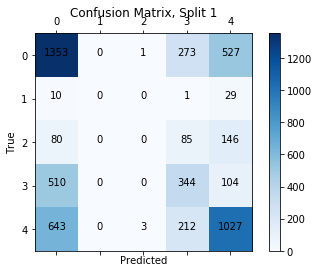

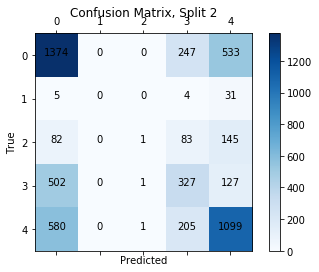

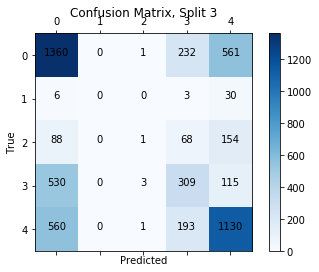

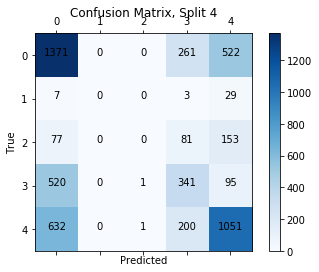

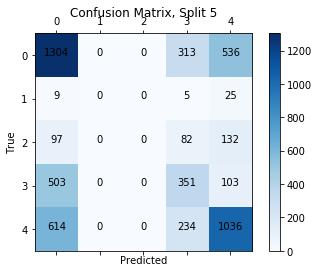

In [76]:
clf_MNB = MultinomialNB()

print('Oversampled:')
stratfit(clf_MNB, train_data_os, train_labels_os, n_splits=5)
f1_dict['Multinomial Naive Bayes with Oversampled Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

print('\nOriginal data:')
stratfit(clf_MNB, train_data, train_labels, n_splits=5)
f1_dict['Multinomial Naive Bayes with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

As expected, the Multinomial Naive Bayes classifier did not perform well, and was not worth exploring further. We are not surprised that the Multinomial Naive Bayes classifier did not perform well, because this classifier assumes feature independence, which we know is not the case in our dataset. As we saw from our EDA, the color and breed escriptions are often different for cats and dogs, speaking to feature dependence.

For the oversampled dataset, it returned a weighted f1-score of only ~0.35 for the test kfolds. For the original data, we see slightly better performance. However, we will not use Multinomial Naive Bayes, and are only leaving this in here as an example of a poorly performing model.

## Principal Component Analysis

Our next step is to conduct principal component analysis (PCA) on our dataset. Our goal here is to see if we can reduce our features to their principal components without sacrificing too much of the explained variance. We still have over 200 breed variables, over 50 color variables, and several other features, some of which may not have been necessary, since our sparsity rate is over 94%. This method will likely speed up model fitting and simplify our model.

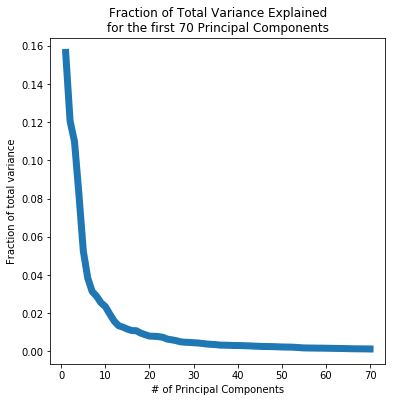

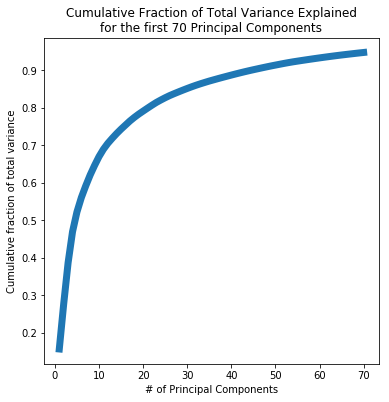

In [77]:
# Figure out best k to use - go up to 70.
k = 70

# Set the number of principal components.
pca = PCA(n_components=k)

# Fit principal component analysis.
pca.fit(train_data_os)

# Store explained variance ratio with corresponding k.
results = np.column_stack(([i for i in range(1, k+1)],pca.explained_variance_ratio_))

# Plot the relationship of explained variance ratio.
fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111)
ax.set_title('Fraction of Total Variance Explained' 
             '\nfor the first {} Principal Components'.format(k)
            )
plt.plot([i for i in range(1, k+1)],pca.explained_variance_ratio_, linewidth=7.0)
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Fraction of total variance')
fig1.show()

# Plot the cumulative explained variance ratio.
fig2 = plt.figure(figsize = (6,6))
ax = fig2.add_subplot(111)
ax.set_title('Cumulative Fraction of Total Variance Explained' 
             '\nfor the first {} Principal Components'.format(k)
            )
plt.plot([i for i in range(1, k+1)], np.cumsum(pca.explained_variance_ratio_), linewidth=7.0)
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Cumulative fraction of total variance')
fig2.show()

When we look at the cumulative explained variance of 70 principal components, we see rather quickly that 30 principal components (our k) explained almost 90% of the variance within our dataset. We will now run a RandomForest classifier, our method of choice, with our PCA analysis taking 284 features down to 30 principal components.

In [78]:
# Set the number of principal components.
pca = PCA(n_components=30)

# Fit and transform based on train data, but oversampled.
projected_X_train_os = pca.fit_transform(train_data_os)
projected_X_train = pca.transform(train_data)

# Run PCA on test_data as well, so that we have a consistent number of features.
projected_X_test = pca.transform(test_data)


TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.79      0.76      0.77      8615
           Died       0.78      0.95      0.86      8615
     Euthanasia       0.73      0.77      0.75      8615
Return_to_owner       0.77      0.77      0.77      8615
       Transfer       0.79      0.60      0.68      8615

      micro avg       0.77      0.77      0.77     43075
      macro avg       0.77      0.77      0.77     43075
   weighted avg       0.77      0.77      0.77     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.66      0.62      0.64      2154
           Died       0.78      0.95      0.85      2154
     Euthanasia       0.70      0.73      0.71      2154
Return_to_owner       0.65      0.67      0.66      2154
       Transfer       0.64      0.48      0.55      2154

      micro avg       0.69      0.69      0.69     10770
      macro avg    

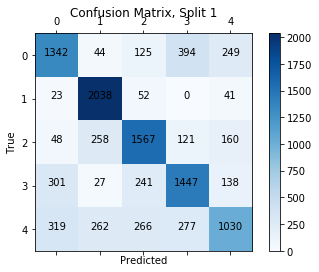

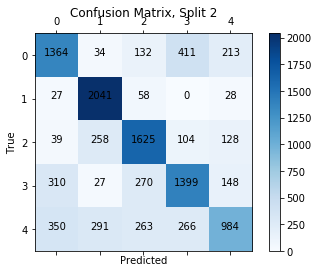

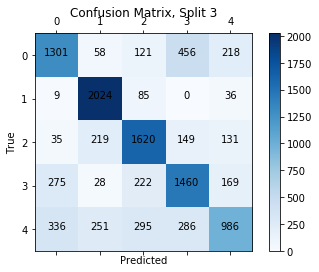

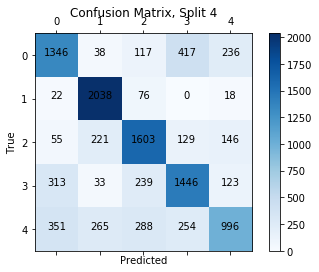

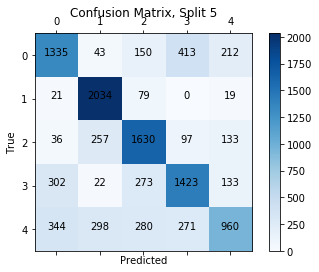

In [79]:
clf_RF = RandomForestClassifier()
stratfit(clf_RF, projected_X_train_os, train_labels_os, n_splits=5)
cv_scores_dict['8. Random Forest\nwith Oversampled,\nProjected Data'] = check_variance(clf_RF
                                                                                       , projected_X_train_os
                                                                                       , train_labels_os
                                                                                       , n_splits=5
                                                                                      )
f1_dict['Random Forest with Oversampled, Projected Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

While the weighted f1-score predictive performance did not improve on the random forest classifier with the addition of PCA, the model has a much faster run time, which would be important in a production environment. Given this finding, we choose to continue to optimize our algorithm with a random forest classifier on the oversampled PCA dataset.

## Summary of Model F1-Scores

We have looked at many varieties of classifiers. Some are interesting, some are not. We have evaluated the differences in f1-scores. While these differences may seem obvious, we want to make sure we do hypothesis tests to check if they are, indeed, statistically significantly different. In order to do this, we created a `cv_scores_dict` to store the f1-scores from 5 cross-validation fits for each classifier. We convert this to a pandas data frame below.

In [80]:
# Create pandas dataframe with all f1-scores for all classifiers of interest.
cv_scores_df = pd.DataFrame.from_dict(cv_scores_dict)
print('Weighted F1-Score Distributions')
cv_scores_df

Weighted F1-Score Distributions


1. Logistic Regression\nwith Raw Data  2. Decision Tree\nwith Raw Data  \
0                               0.591879                         0.587784   
1                               0.595342                         0.588425   
2                               0.591042                         0.593996   
3                               0.584260                         0.590098   
4                               0.596984                         0.579116   

   3. Random Forest\nwith Raw Data  4. XGBoost\nwith Raw Data  \
0                         0.580303                   0.602546   
1                         0.590345                   0.612773   
2                         0.575699                   0.610277   
3                         0.578653                   0.590680   
4                         0.585236                   0.609197   

   5. Logistic Regression\nwith Oversampled Data  \
0                                       0.471428   
1                                       0.480132   
2                                       0.478297   
3                                       0.465702   
4                                       0.484045   

   6. Random Forest\nwith Oversampled Data  7. XGBoost\nwith Oversampled Data  \
0                                 0.686789                           0.527570   
1                                 0.685224                           0.520553   
2                                 0.686816                           0.524376   
3                                 0.693877                           0.524412   
4                                 0.686657                           0.520381   

   8. Random Forest\nwith Oversampled,\nProjected Data  
0                                           0.685346    
1                                           0.683330    
2                                           0.681255    
3                                           0.682846    
4                                           0.690014

Now, we would like to plot the mean f1-score for each of the classifier/data combinations we have tested above. In order to test if the f1-scores are statistically significantly different from each other, we can do two-sample t-tests for pairs of classifiers. Alternatively, we can evaluate the 95% confidence intervals for the f1-scores for the classifier/data combinations.  We plot this 95% confidence interval below. The f1-scores are significantly different in all cases in which confidence intervals do not overlap.

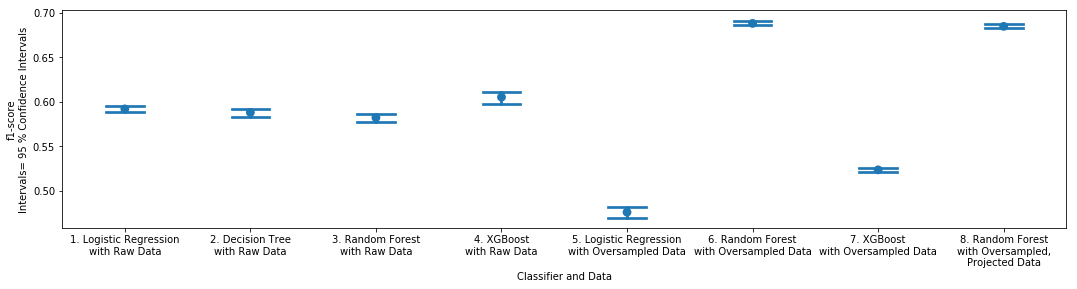

In [81]:
# Plot interval plot of 95 % confidence intervals for f1 scores for all interesting classifiers from above.
plt.figure(figsize=(18, 4))
ax = sns.pointplot(data=cv_scores_df, join=False, capsize=.3, s=.2)
ax.set_xticklabels(ax.get_xticklabels())
plt.xlabel("Classifier and Data")
plt.ylabel("f1-score\nIntervals= 95 % Confidence Intervals")
plt.show()

We can see here that the f1-scores for the classifiers fit with raw data are significantly lower than the random forest classifiers fit with oversampled data. The two random forest classifiers fit with oversampled data or oversampled and projected data and the XGBoost classifier do not show any difference in f1-scores. Because of this, and the faster speed of fitting the PCA projected data, **we choose the random forest classifier fit with oversampled, projected data to optimize further**.

# Optimize the Best Algorithm (Random Forest)

Now, we optimize the random forest. We will select more parameters to vary and use `GridSearchCV` to make sure we are happy with the performance. 

We will perform a GridSearch on our random forest classifier to identify its best parameters. We want to fine tune the parameters max_depth, min_samples_split, the criterion, and the n_estimators in order to improve the model's ability to generalize.

In [82]:
# This code optimizes a random forest classifier.
clf = RandomForestClassifier()

param = {'max_depth': np.arange(20,120,20)
         , 'min_samples_split': np.arange(4,10,2)
         # , 'n_estimators': np.arange(10, 120, 30); decided not to pursue for speed
         , 'criterion': ['gini', 'entropy']}

# Optimize classifier, use f1_weighting, use 5 StratifiedKFolds.
clf_best_param = GridSearchCV(clf, param_grid = param, cv=5, scoring = 'f1_weighted')

# Fit optimized classifier.
clf_best = clf_best_param.fit(projected_X_train_os, train_labels_os)

# Predict values on regular data.
pred_labels = clf_best_param.predict(projected_X_train)

# Print best classifier.
print(clf_best_param)

# Print classification report.
print(classification_report(train_labels, pred_labels))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 20,  40,  60,  80, 100]), 'min_samples_split': array([4, 6, 8]), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)
                 precision    recall  f1-score   support

       Adoption       0.81      0.76      0.78     10769
           Died       0.11      0.82      0.19       197
     Euthanasia       0.38   

In [83]:
print(clf_best.best_params_)

{'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 4}


Changing the number of estimators (number of trees in each decision forest) took a very long time in conjunction with all of the other parameters. We tried the above classifier with n_estimators=120, and saw no improvement over the default of n_estimators=10. In the interest of speed, we eliminated the n_estimators from our `GridSearchCV`.

Next, we run the best model output by the `GridSearchCV`.


TRAIN: 43075 and TEST: 10770

For train data:
                  precision    recall  f1-score   support

       Adoption       0.80      0.74      0.77      8615
           Died       0.79      0.94      0.86      8615
     Euthanasia       0.72      0.77      0.74      8615
Return_to_owner       0.76      0.77      0.77      8615
       Transfer       0.77      0.61      0.68      8615

      micro avg       0.77      0.77      0.77     43075
      macro avg       0.77      0.77      0.76     43075
   weighted avg       0.77      0.77      0.76     43075

For test data:
                  precision    recall  f1-score   support

       Adoption       0.67      0.62      0.65      2154
           Died       0.79      0.94      0.86      2154
     Euthanasia       0.69      0.77      0.73      2154
Return_to_owner       0.64      0.67      0.65      2154
       Transfer       0.65      0.48      0.55      2154

      micro avg       0.69      0.69      0.69     10770
      macro avg    

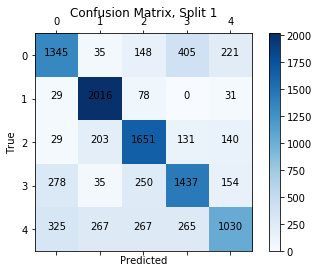

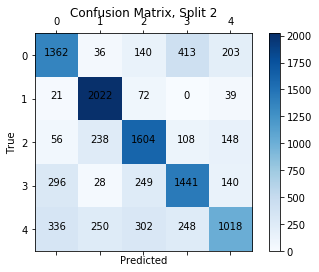

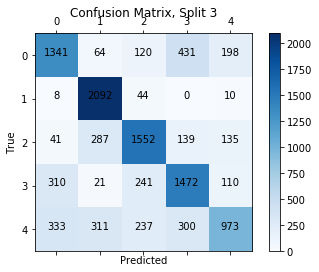

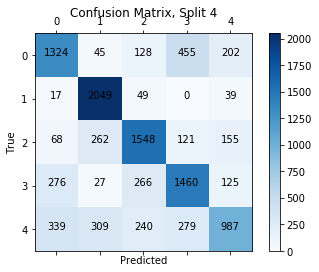

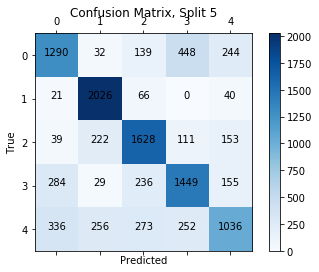

In [84]:
# Run random forest with the best parameters.
clf_RF = RandomForestClassifier(max_depth=40, min_samples_split=4, criterion='gini')
stratfit(clf_RF, projected_X_train_os, train_labels_os, n_splits=5)

We found that the best parameters included a max_depth of 40, minimum_sample_split of 4, and criterion gini. The max_depth represents the maximum depth of each decision tree, or the maximum number of levels of each of those trees. The min_samples_split is the minimum number of observations or samples placed in a node before the node is split. We had to evaluate a balance with min_samples_split, as one data point per node would not help us generalize to test data, but each node could be more constrained as more samples have to be included. The same rule of balance goes for max_depth, as too many levels would make it hard for our algorithm to generalize on training data. Limiting the depth of the trees in our random forest helps reduce the number of important features. The criterion in this instance refers to the quality of each node split within our tree. The gini criterion was chosen as the best parameter over the entropy criterion. This measures how often a randomly chosen observation within our training data would be mislabeled.

Overall, the random forest classifier improved less than 1 percentage point on the weighted f1-score with the addition of PCA and the optimized GridSearchCV, while it improved around 10 percentage points with the addition of oversampling. From this point, we move to error analysis.

### Check variance on best algorithm

In [85]:
cv_scores = check_variance(clf_RF, projected_X_train_os, train_labels_os, n_splits=100)

Variance: 1.4857882395481882e-05
The 95 % confidence interval for the f1_score is: (0.6754, 0.6905)


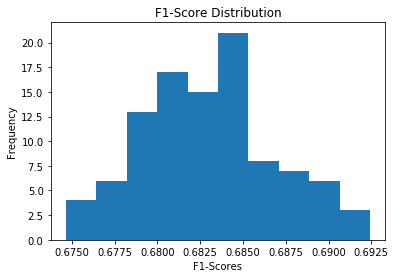

In [86]:
# Calculate variance.
variance = np.var(cv_scores)

# Plot the histogram.
plt.hist(cv_scores) 
plt.title("F1-Score Distribution")
plt.xlabel("F1-Scores")
plt.ylabel("Frequency")

# Calculate the 95 % confidence interval.
print('Variance: {}'.format(variance))
print('The 95 % confidence interval for the f1_score is: ({:.4f}, {:.4f})'
      .format(np.mean(cv_scores) - 1.96*variance**0.5
              ,np.mean(cv_scores) + 1.96*variance**0.5))

# Model Error Analysis

With all of the experiments above, we have only been able to improve performance over the out-of-the-box random forest classifier marginally. Let's do some error analysis to understand where the algorithm is making mistakes so that we might have a better chance of future improvement.

For our error analysis, our goal is to look into the confusion matrices that we have been generating to understand further which features existed when certain observations were mislabeled for other classes in our training folds. 

In [87]:
# Error analysis.
def print_matrix2(matrix, title, features):
    '''This function takes in a matrix, and plots it with the title and 
    features to be used as ylabels.
    '''
    
    fig = plt.figure(figsize = (10, 50))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap = 'Blues')
    plt.title('{}'.format(title))
    #fig.colorbar(cax)
    plt.xticks(np.arange(1, matrix.shape[1] + 1, step=1))
    plt.yticks(np.arange(0, matrix.shape[0], step=1))
    ax.set_yticklabels(features)
    plt.xlabel('Example')
    plt.ylabel('Feature')
    return fig

def find_and_show_errors(fit_labels_true, train_data, 
                         pred_labels, indices_test, 
                         labels, N=2, J=5):
    '''This function takes in the number of errors, N, the true labels, fit_labels_true,
    and the predicted labels, pred_labels.  It outputs the confusion matrix, 
    and shows J examples of each of the errors.
    '''
    
    # Print labels.
    print('Label Legend')
    labels = labels
    for i, label in enumerate(labels):
        print('{}: {}'.format(i, label))
    
    # Print the confusion matrix.
    print('\nConfusion Matrix')
    cm = confusion_matrix(fit_labels_true, pred_labels)
    plt.show(print_matrix(cm, 'Error Analysis'))

    # Find the highest N confused digits in the CM.
    # These are the highest N numbers in the CM that are not on the diagonal.
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, -1)
    error_pairs = np.unravel_index(np.argsort(cm_copy.ravel())[-N:], cm.shape)
    
    # Create a list of features.
    features_list = train_data_pd.columns.tolist()
    
    # Loop through the predicted values (error_pairs[0]), one loop for each predicted/true pair.
    print('Top Errors:')
    for [index, value] in enumerate(error_pairs[0]):
        # Store the predicted value and the true value for the error.
        true, pred = error_pairs[0][-index-1], error_pairs[1][-index-1]
        print('\033[1m' + '\n{} is predicted when the true value is {}: {} times.'.format(labels[pred]
                                                                               , labels[true]
                                                                               , cm[true, pred]   
                                                                              )
             )
        print('\033[0m')
        # Find all the examples of the errors.
        
        miss_arr = np.where((fit_labels_true == labels[true]) & (pred_labels == labels[pred]))
        
        # Print all of the examples of the errors.
        # j is the number of the particular error, row is where it occurs in digits and fit_data.
        print('Examples of this error:\n')
        for [j, row] in enumerate(miss_arr[0]):
            if j < J:
                # Print only non-zero features. This saves much space.
                print('Example {}: Non-zero features:'.format(j + 1))
                for i, feature_val in enumerate(train_data[indices_test][row]):
                    if feature_val != 0:
                        print('\t', features_list[i])
                    else:
                        continue
                print('All other features equal to 0.\n')
            else:
                continue
        
        # Print plots.
        # Initialize array with number of feature rows and number of mistake columns.
        error_examples = np.empty((len(features_list), J))
        # Iterate through each error.
        for [j, row] in enumerate(miss_arr[0]):
            # j is the number of the particular error, row is where it occurs in digits and fit_data.
            if j < J:
                for i, feature_val in enumerate(train_data[indices_test][row]):
                    # Set the value of the particular feature.
                    error_examples[i, j] = feature_val
            else:
                continue
                
        # Print error heat maps.
        print_matrix2(error_examples
                      , '{} is predicted when the true value is {}: {} times.'
                      .format(labels[pred], labels[true], cm[true, pred])
                      , features_list)

We will check the performance and do error analysis with a single split of the training data into test and training subsets. We do not need to use multiple kfolds because we are trying to evaluate general errors and guide feature engineering. These errors would likely not change much, regardless of the fold, since the variance in predictive performance was low between each fold. 

In [88]:
# Split training, oversampled, projected data into training and test. 
indices = np.asarray(range(len(projected_X_train_os)))
X_train, X_test, y_train, y_test, indices_train, indices_test= train_test_split(projected_X_train_os
                                                                              , train_labels_os
                                                                              , indices
                                                                              , test_size = .25
                                                                              , stratify = train_labels_os
                                                                              , random_state = 99)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(indices_train.shape)
print(indices_test.shape)

(40383, 30)
(13462, 30)
(40383,)
(13462,)
(40383,)
(13462,)


Label Legend
0: Adoption
1: Died
2: Euthanasia
3: Return_to_owner
4: Transfer

Confusion Matrix


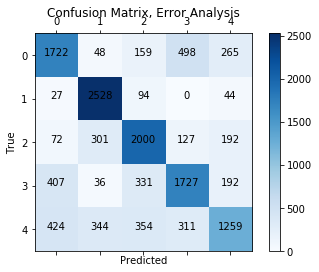

Top Errors:

Return_to_owner is predicted when the true value is Adoption: 498 times.

Examples of this error:

Example 1: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Dachshund
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 State(Fixed=1)
	 Great Pyrenees
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Labrador Retriever
	 Yellow
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Labrador Retriever
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 State(Fixed=1)
	 Chihuahua Shorthair
	 Tan
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 State(Fixed=1)
	 Dachshund
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 7: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Manx
	 Black


	 State(Fixed=1)
	 Domestic Shorthair
	 Torbie
	 AgeuponOutcome_norm
All other features equal to 0.

Example 21: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Chihuahua Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 22: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 23: Non-zero features:
	 State(Fixed=1)
	 Domestic Shorthair
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 24: Non-zero features:
	 State(Fixed=1)
	 Staffordshire
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 25: Non-zero features:
	 State(Fixed=1)
	 German Shepherd
	 Tan
	 AgeuponOutcome_norm
All other features equal to 0.

Example 26: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Chihuahua Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 27: Non-zero features:
	 State(Fixed=1)
	 Boxer
	 White
	 Ageu


Euthanasia is predicted when the true value is Transfer: 354 times.

Examples of this error:

Example 1: Non-zero features:
	 Labrador Retriever
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 Dachshund Wirehair
	 Tan
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Orange Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 State(Fixed=1)
	 Pit Bull
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 Gender(Male=1)
	 Domestic Shorthair
	 Orange Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 7: Non-zero features:
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 8: Non-zero features:
	 State(Fixed=

	 Domestic Shorthair
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 40: Non-zero features:
	 Domestic Shorthair
	 Black
All other features equal to 0.


Euthanasia is predicted when the true value is Return_to_owner: 331 times.

Examples of this error:

Example 1: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Border Collie
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 State(Fixed=1)
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Pit Bull
	 Brown
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 Gender(Male=1)
	 Pit Bull
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Pit Bull
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 State(Fixed=1)
	 Labrador

	 State(Fixed=1)
	 Gender(Male=1)
	 Catahoula
	 Blue Merle
	 AgeuponOutcome_norm
All other features equal to 0.

Example 40: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Beagle
	 Tricolor
	 AgeuponOutcome_norm
All other features equal to 0.


Died is predicted when the true value is Euthanasia: 301 times.

Examples of this error:

Example 1: Non-zero features:
	 Domestic Shorthair
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 Gender(Male=1)
	 Chihuahua Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 Gender(Male=1)
	 Chihuahua Shorthair
	 Brown
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 Domestic Medium Hair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 Domestic Shorthair
	 T

	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Orange Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 40: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.


Transfer is predicted when the true value is Euthanasia: 192 times.

Examples of this error:

Example 1: Non-zero features:
	 Domestic Shorthair
	 Calico
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 Gender(Male=1)
	 Domestic Shorthair
	 Brown Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 Domestic Shorthair
	 Brown Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 Domest

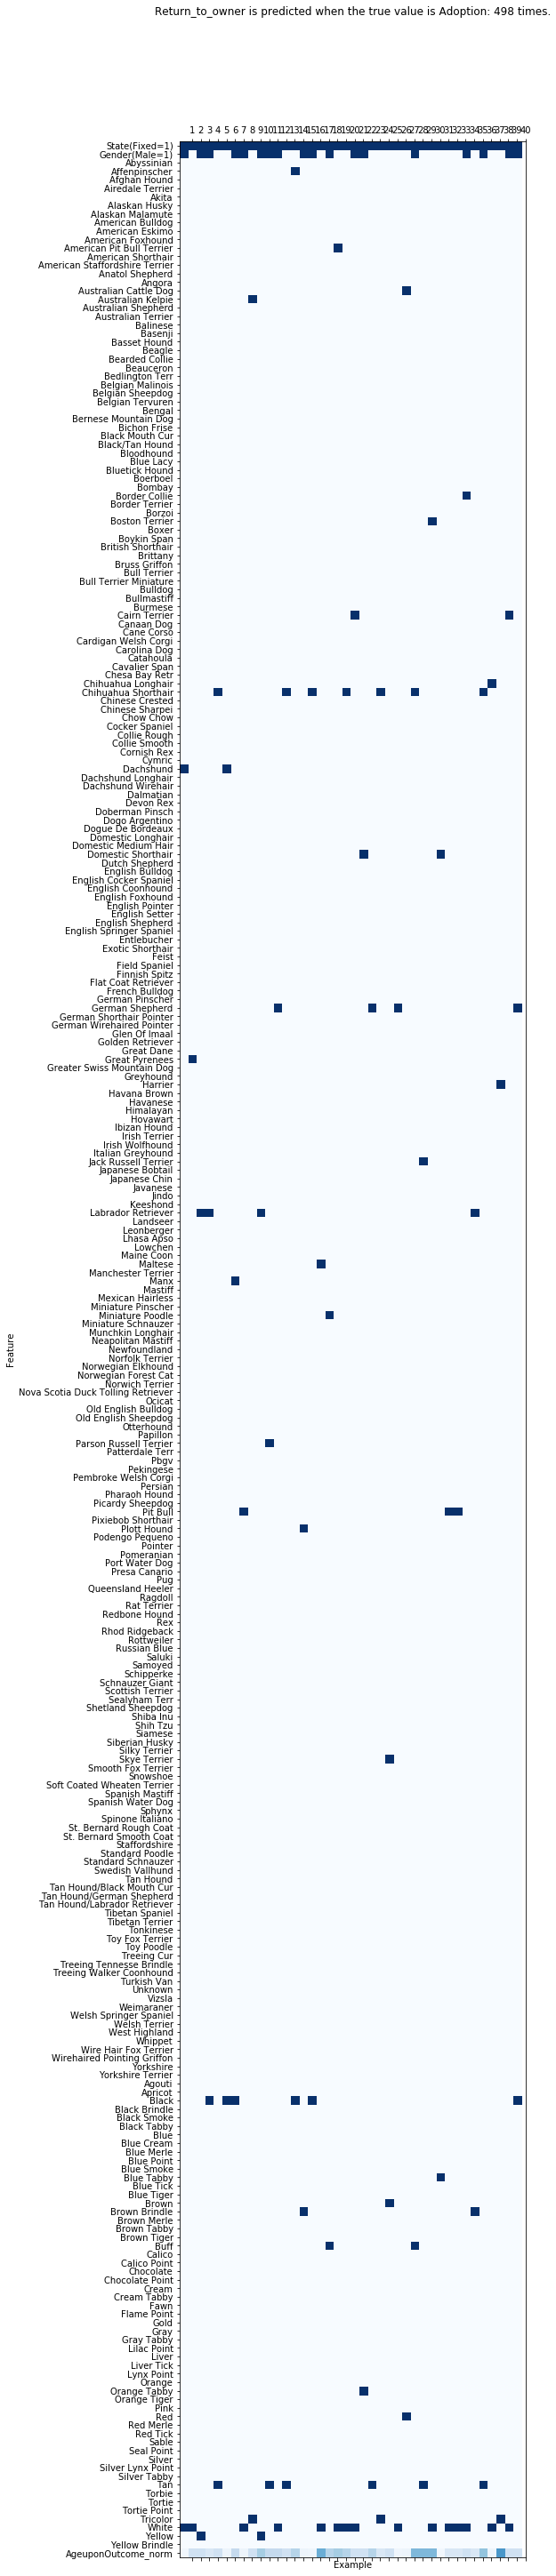

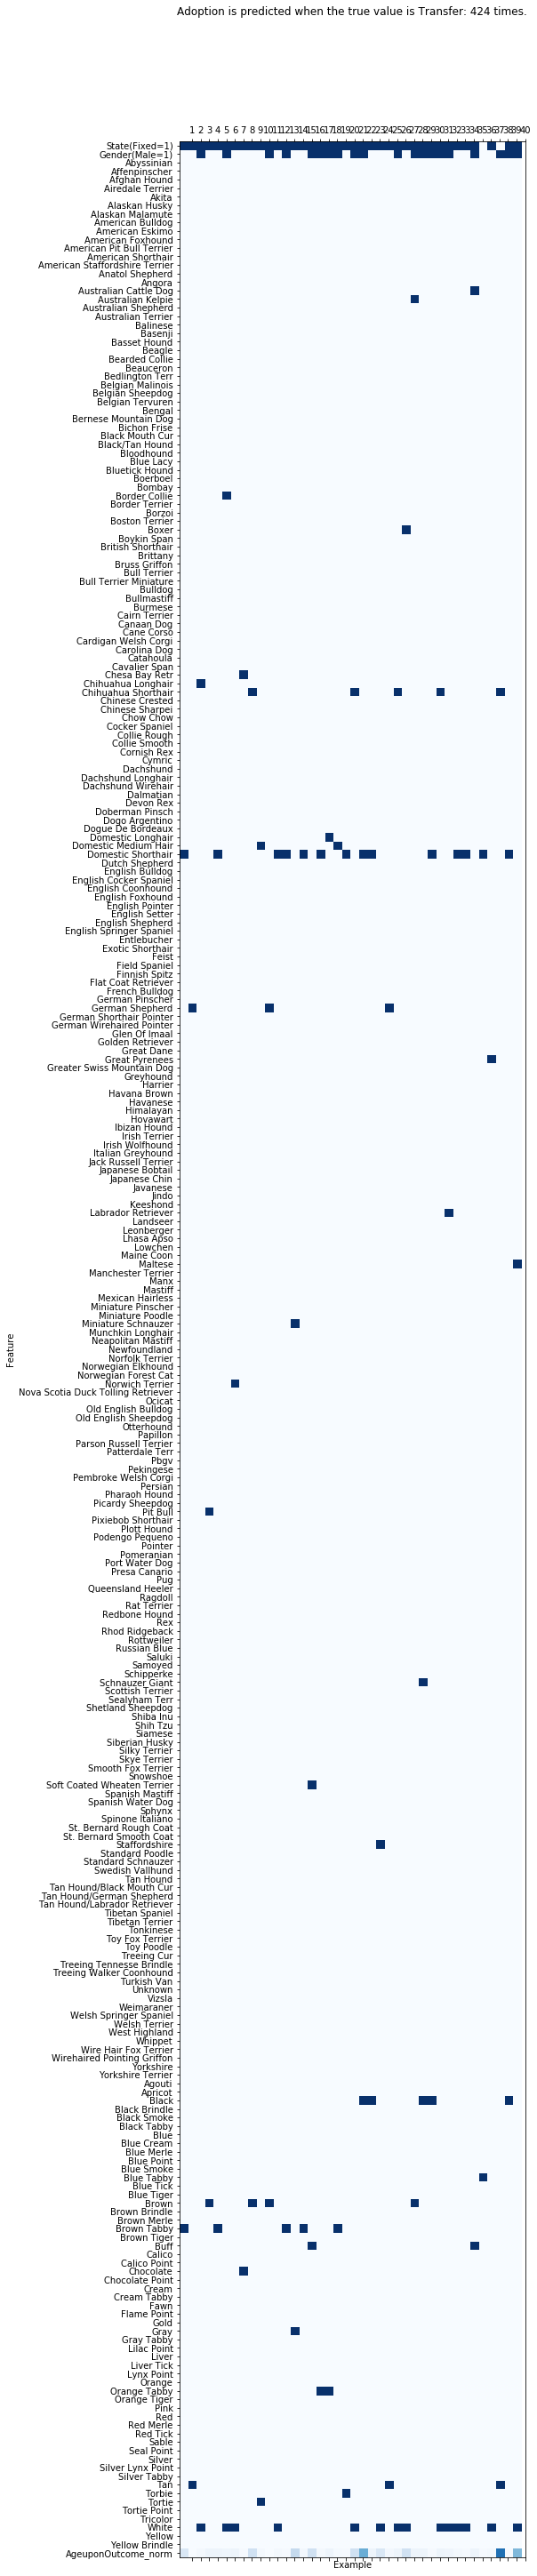

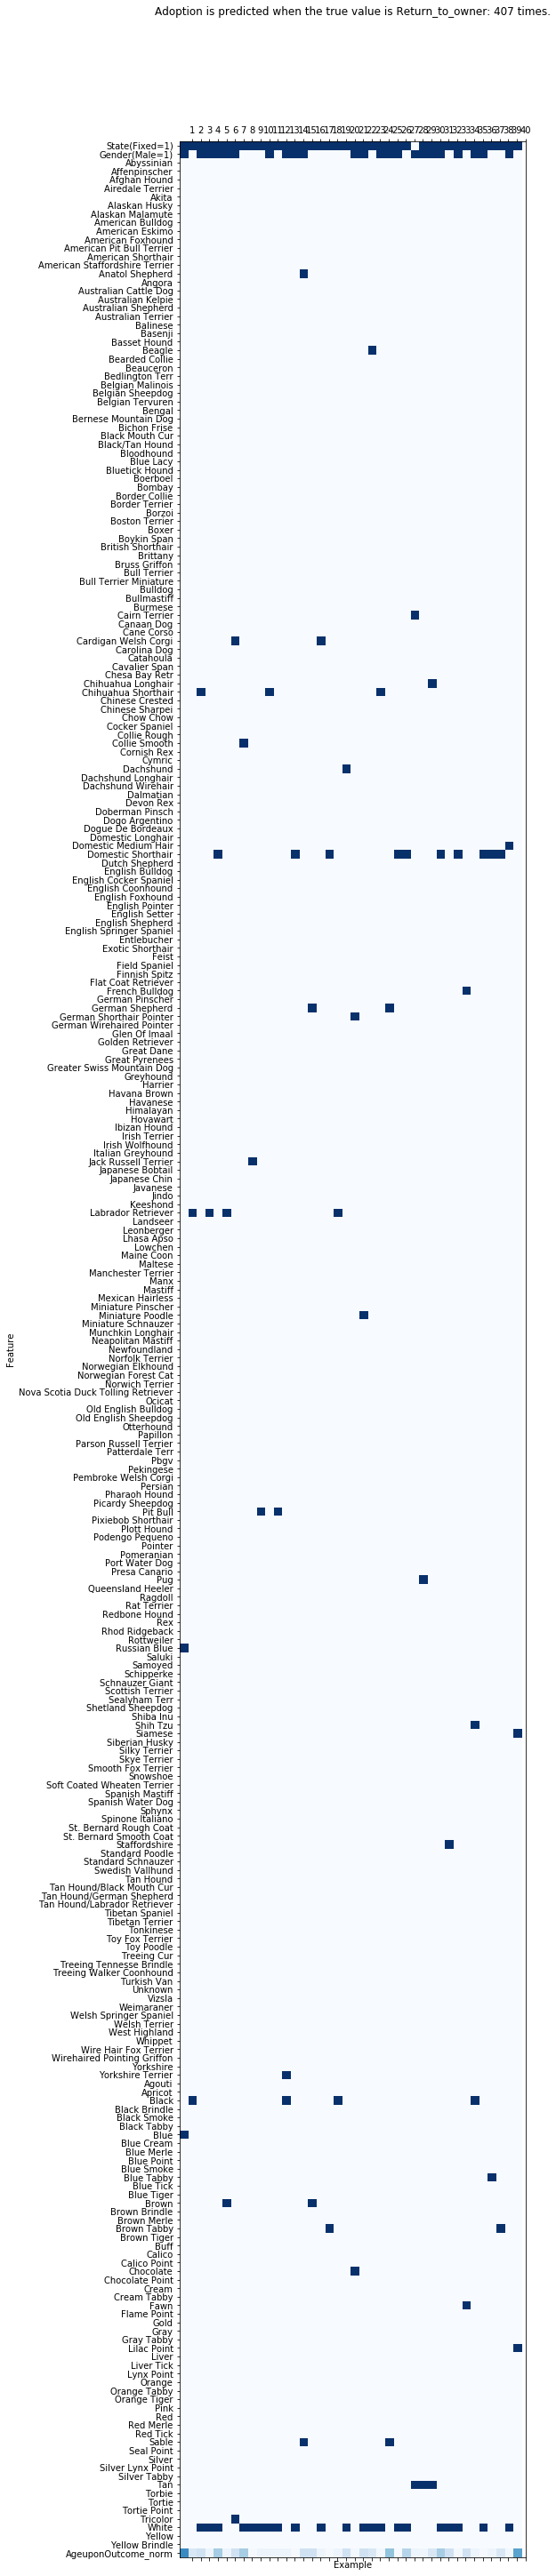

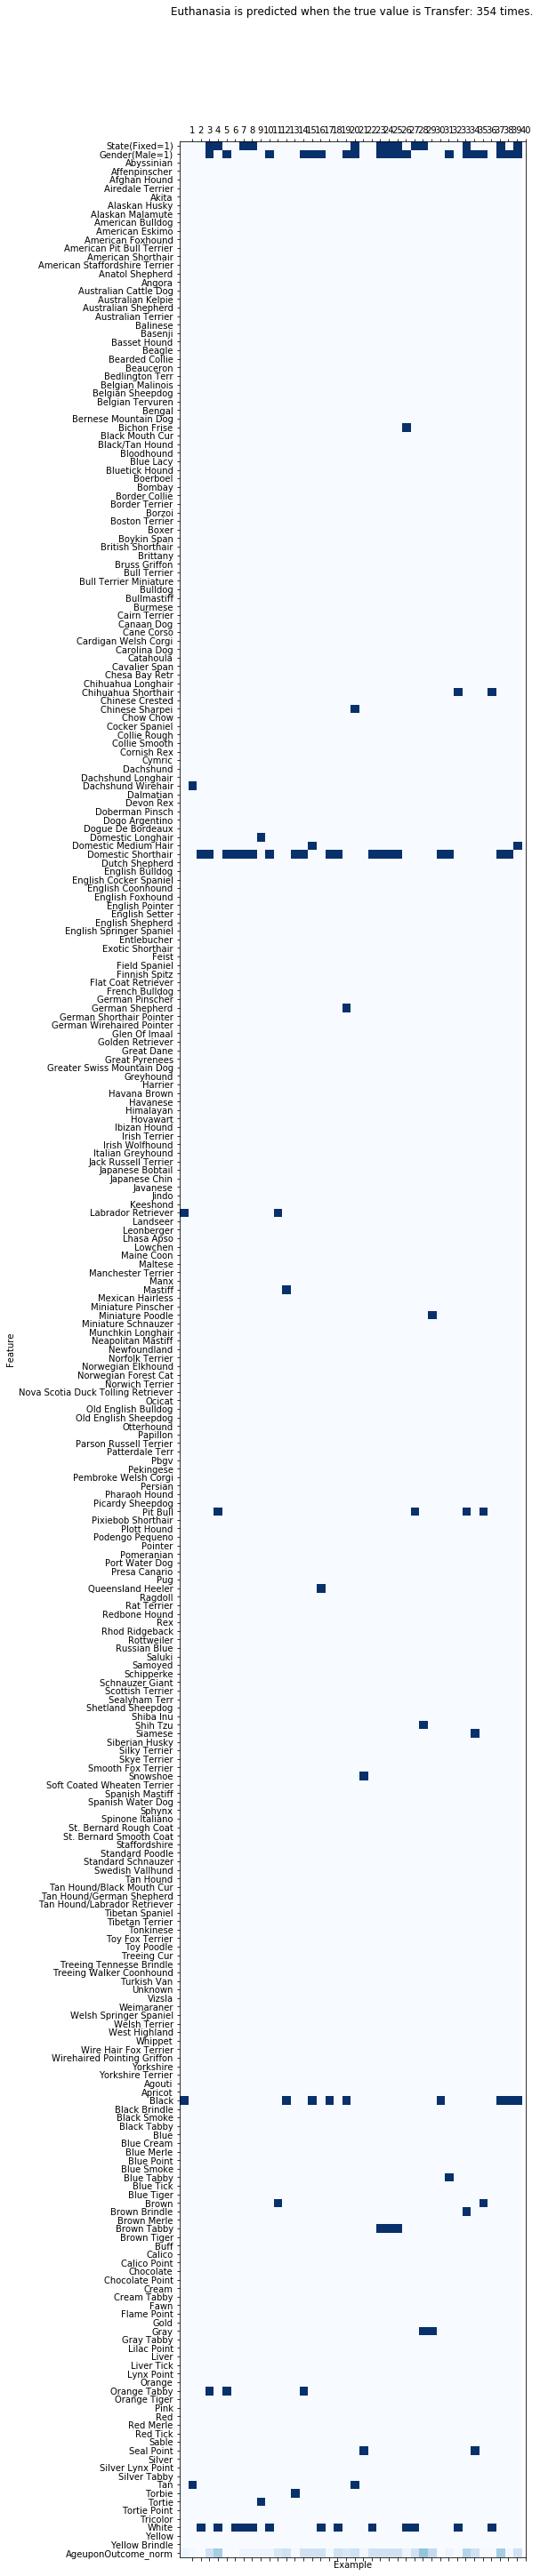

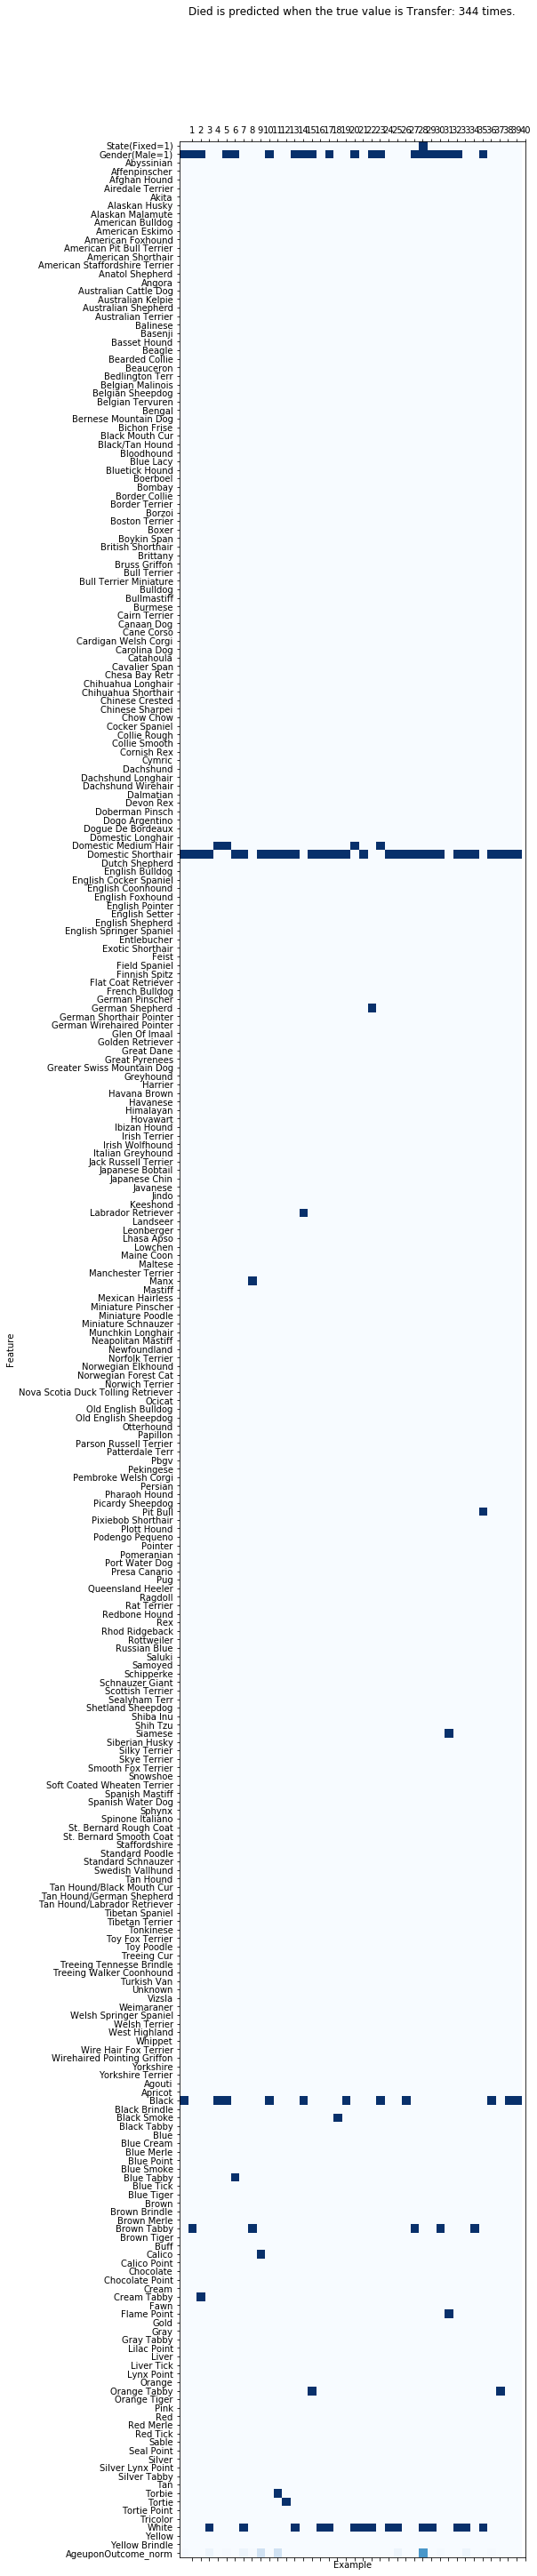

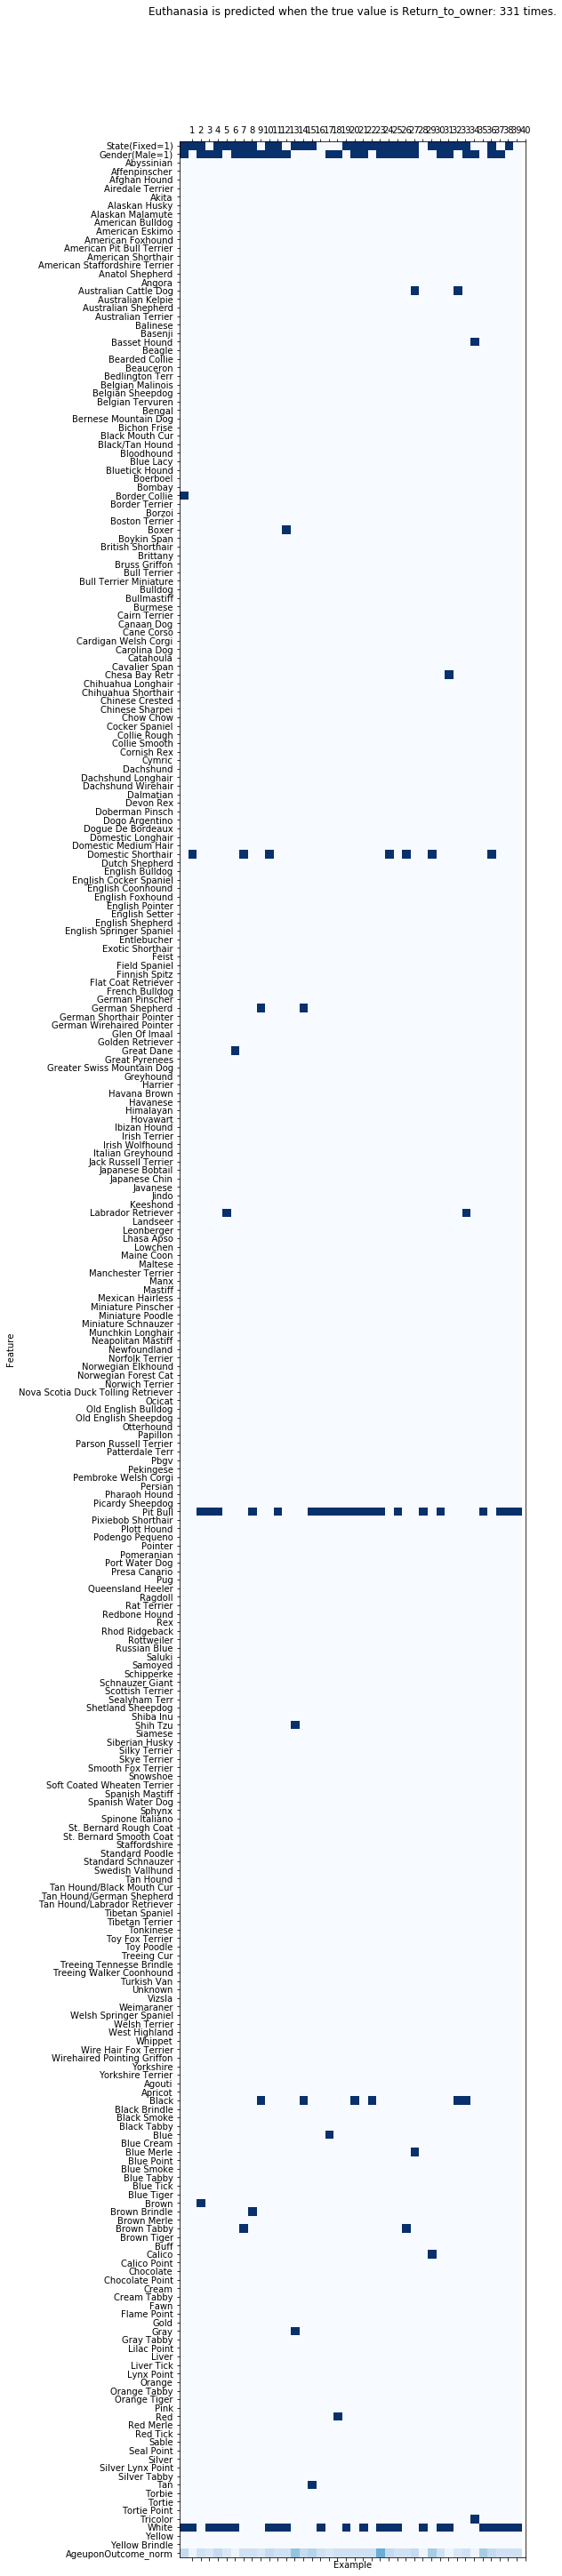

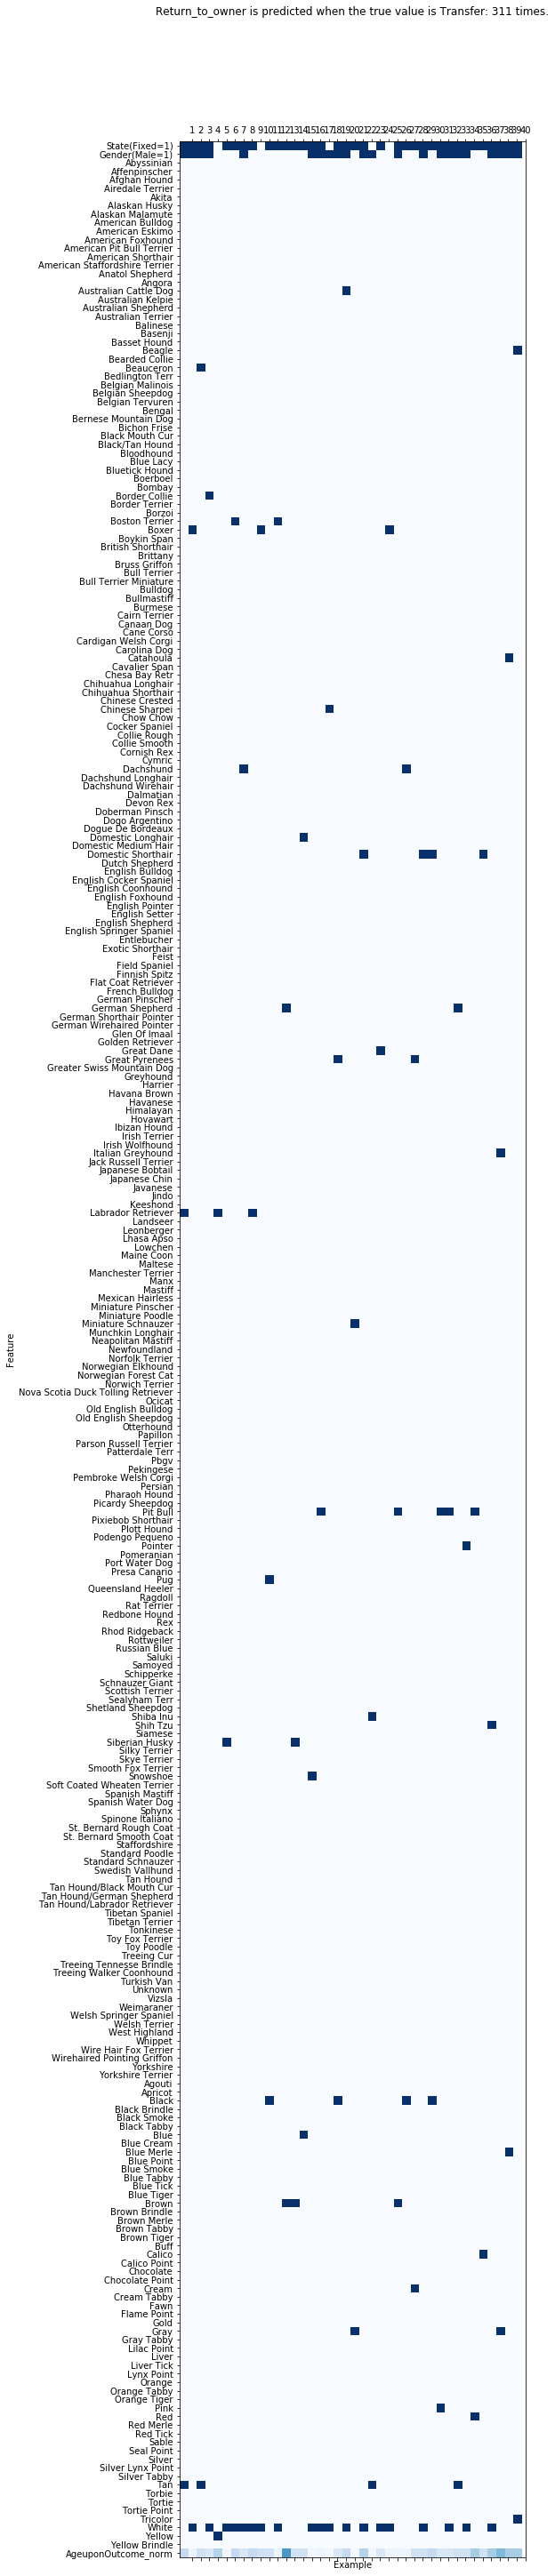

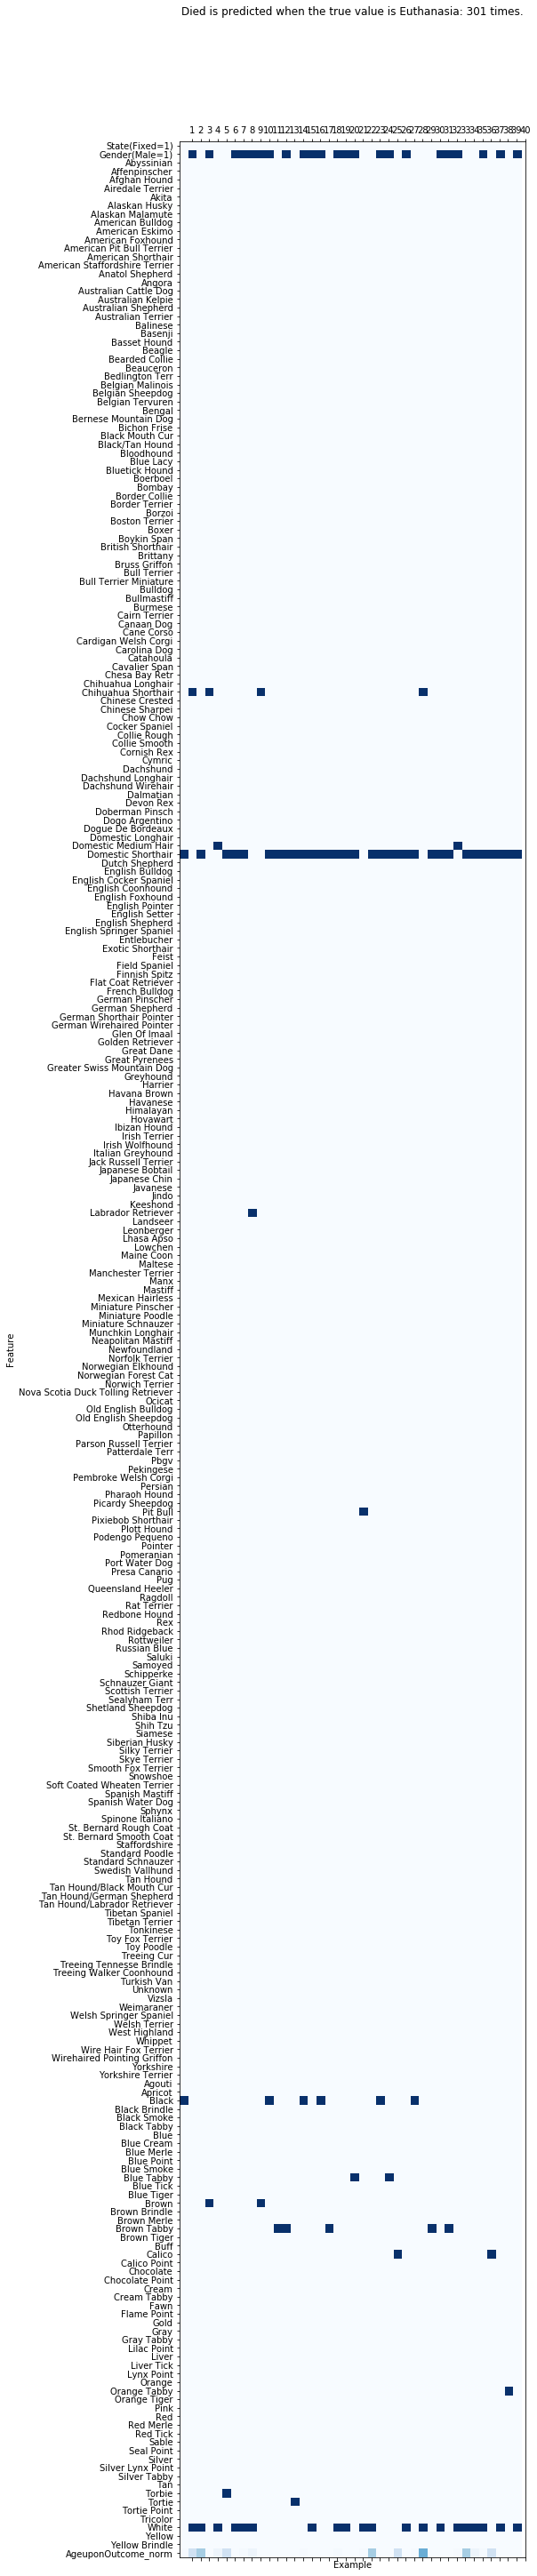

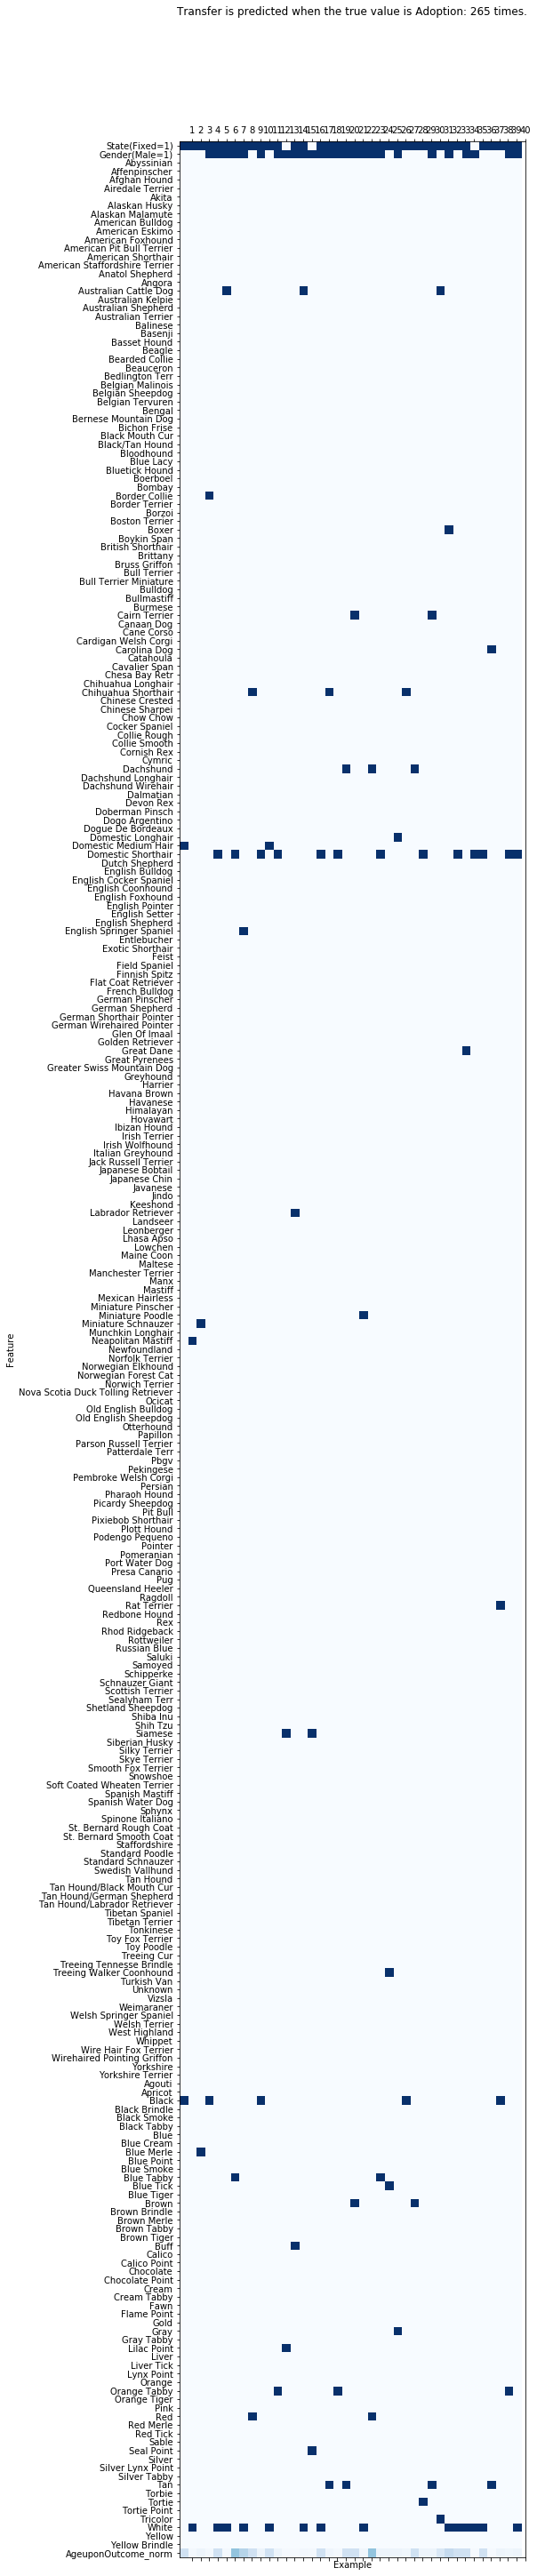

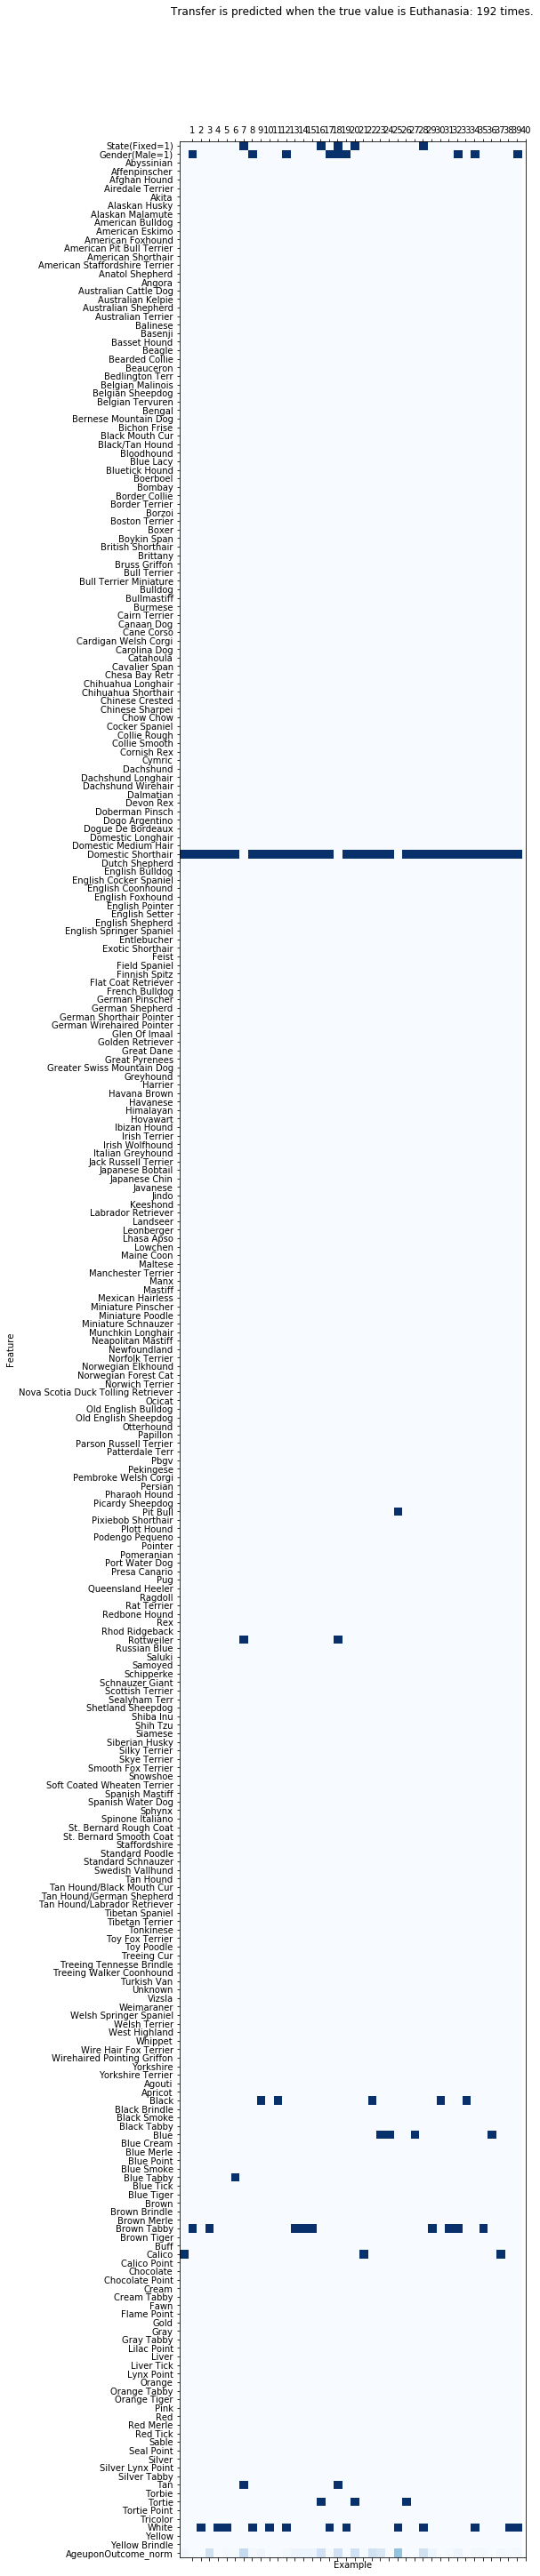

In [89]:
# Fit the optimal model.
clf_RF = RandomForestClassifier(max_depth=80, min_samples_split=6, criterion='entropy')
clf_RF.fit(X_train, y_train)
pred_labels = clf_RF.predict(X_test)

labels  = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
# Find the errors for the optimal model.
find_and_show_errors(fit_labels_true=y_test, train_data=train_data_os
                     , pred_labels=pred_labels, indices_test=indices_test
                     , labels=labels, N=10, J=40
                    )


The plots of error examples are at the end of the above error analysis output.

We evaluated the most common types of errors. In fact, on our first pass, the error analysis helped us identify that our AgeuponOutcome variable was not split finely enough. We went back and simply normalized the age, in weeks, and this improved our performance by almost 6%. (The first pass is not shown in our notebook.) 

The error analysis, however, is difficult to interpret, due to the sparsity of our dataset. The trends in the common mistakes are difficult to decipher. Very common breeds, such as domestic shorthairs, seem to be mispredicted as “transfer” or “died”, when the actual label was frequently euthanasia; this was especially common for cats. As the domestic shorthair breed appears for both cats and dogs, our model was getting confused on the prediction class. We briefly looked at the effect of adding interaction features in our models  which can be seen in the code below (i.e. domestic shorthair * animal type) for further improvements, but we decided not to include this feature, as we saw no significant improvement.

>train_data_pd = train_df_binarization.iloc[: , 13:]
>train_labels_pd = train_df_binarization['OutcomeType']
>train_data_pd['AnimalType_x_DomesticShorthair'] = >train_data_pd['AnimalType_Binarize(Dog=1)']* train_data_pd['Domestic Shorthair']
>train_data_pd['AnimalType_x_White'] = train_data_pd['AnimalType_Binarize(Dog=1)']* >train_data_pd['White']
>train_data_pd.head()

# Test Performance and Predict on the Test Data

Now that we have satsifactorily optimized our random forest classifier and conducted error analysis on the outcome classes where our model was not performing at its best, we will test our performance. We decided to test our performance by evaluating the log loss function of our classifiers. Log loss analyzes the accuracy of our random forest classifier, as it penalizes false predictions, and it is the measure used in the Kaggle competition. Our goal here will be to minimize the log loss function, or at least decrease it substantially with respect to our dummy classifier.

Here, we will test the winning algorithm and show the best performance we have been able to achieve, as well as evaluate our log loss function.

In [90]:
# Show the f1_dict, where we have been storing f1 values.
f1_dict

{'Dumb': ['0.40', '0.23', ''],
 'Logistic Regression with Raw Data': ['0.63', '0.59', ''],
 'Decision Tree with Raw Data': ['0.59', '0.58', ''],
 'Random Forest with Raw Data': ['0.60', '0.58', ''],
 'XGBoost with Raw Data': ['0.63', '0.61', ''],
 'Logistic Regression with Oversampled Data': ['0.50', '0.47', ''],
 'Random Forest with Oversampled Data': ['0.69', '0.69', ''],
 'XGBoost with Oversampled Data': ['0.53', '0.52', ''],
 'Random Forest with Undersampled Data': ['0.39', '0.38', ''],
 'Multinomial Naive Bayes with Oversampled Data': ['0.40', '0.35', ''],
 'Multinomial Naive Bayes with Raw Data': ['0.52', '0.50', ''],
 'Random Forest with Oversampled, Projected Data': ['0.69', '0.68', '']}

In [91]:
# What is the log loss of the "dumb" classifier that predicts all adoption?

# Create numpy array, pred_prob, that predicts all adoption.
pred_prob = np.zeros((len(train_labels),5))
pred_prob[:, 0] = 1
                  
# Calculate and print log_loss metric for the dumb classifier.
log_loss_metric = log_loss(train_labels, pred_prob
                           , labels=['Adoption'
                                     , 'Died'
                                     , 'Euthanasia'
                                     , 'Return_to_owner'
                                     , 'Transfer'
                                    ]
                          )
f1_dict['Dumb'][2] = '{:.2f}'.format(log_loss_metric)
print('Log loss for the dumb classifier is {:.2f}.'.format(log_loss_metric))

Log loss for the dumb classifier is 20.62.


In [92]:
# Pick our best classifier from above.
clf_optimal = RandomForestClassifier(max_depth=60, min_samples_split=4, criterion='gini')

# Fit it.
clf_optimal.fit(X_train, y_train)

# Predict probabilities.
pred_prob = clf_optimal.predict_proba(X_test)

# Calculate and print log_loss metric.
log_loss_metric = log_loss(y_test, pred_prob
                           , labels=['Adoption'
                                     , 'Died'
                                     , 'Euthanasia'
                                     , 'Return_to_owner'
                                     , 'Transfer'
                                    ]
                          )
print('Log loss for our best classifier is: {:.2f}'.format(log_loss_metric))

Log loss for our best classifier is: 1.69


In [93]:
clfs = [clf_LR, clf_DT, clf_RF, clf_XGB]
logs = []

def logloss(clf):

    # Select classifier.
    clf = clf

    # Fit it
    clf.fit(X_train, y_train)

    # Predict probabilities.
    pred_prob = clf.predict_proba(X_test)

    # Calculate and print log_loss metric.
    log_loss_metric = log_loss(y_test, pred_prob
                               , labels=['Adoption'
                                         , 'Died'
                                         , 'Euthanasia'
                                         , 'Return_to_owner'
                                         , 'Transfer'
                                        ]
                              )
    logs.append('{:.2f}'.format(log_loss_metric))
    print('Log loss: {:.2f}'.format(log_loss_metric))
    
for clf in clfs:
    logloss(clf)

Log loss: 1.24
Log loss: 3.45
Log loss: 1.42
Log loss: 1.10


The log loss of our "dumb" classifier that predicts all shelter animals to fall in the majority class of adoption is 20.62, showing a high degree of inaccuracy in its predictions. Our random forest classifier with the best parameters has a log loss of 1.62; a huge improvement compared to the dumb classifier! We also evaluated the log loss of each of the four classifiers that we have been working with: logistic regression, decision trees, random forests, and XGBoost. The logistic regression and XGBoost had a slightly lower log loss output than the random forest classifier. However, we have to weigh the combination of log loss and weighted f1-score when thinking about the predictive power of an algorithm.

In [94]:
# Append log loss values to scoring dictionary.
f1_dict['Logistic Regression with Raw Data'][2] = logs[0]
f1_dict['Decision Tree with Raw Data'][2] = logs[1]
f1_dict['Random Forest with Raw Data'][2] = logs[2]
f1_dict['XGBoost with Raw Data'][2] = logs[3]

In [95]:
# Make data frame from scoring dictionary.
df = pd.DataFrame(f1_dict)
df = df.transpose()
df.columns = ['Accuracy', 'F1 Score', 'Log Loss']
df

Accuracy F1 Score Log Loss
Decision Tree with Raw Data                        0.59     0.58     3.45
Dumb                                               0.40     0.23    20.62
Logistic Regression with Oversampled Data          0.50     0.47         
Logistic Regression with Raw Data                  0.63     0.59     1.24
Multinomial Naive Bayes with Oversampled Data      0.40     0.35         
Multinomial Naive Bayes with Raw Data              0.52     0.50         
Random Forest with Oversampled Data                0.69     0.69         
Random Forest with Oversampled, Projected Data     0.69     0.68         
Random Forest with Raw Data                        0.60     0.58     1.42
Random Forest with Undersampled Data               0.39     0.38         
XGBoost with Oversampled Data                      0.53     0.52         
XGBoost with Raw Data                              0.63     0.61     1.10

Before submitting our test data class labels, we will perform the same PCA from our training data on our test data for feature congruence. As our test data does not have labeled outcome classes, our submission file will simply show the predicted classes. Our Kaggle competition is fairly old, so we will not be able to have our predicted outcome classes on the test data graded.

In [96]:
# Project test data to 30 principal components.

# Fit principal component analysis, using PCA from above.
print(pca)
projected_X_test = pca.transform(test_data)

# Predict test labels and probabilities.
pred_prob= clf_optimal.predict_proba(projected_X_test)
pred_labels = clf_optimal.predict(projected_X_test)
print(pred_prob)
print(pred_labels)

# Convert the dataset of predicted probabilities to a dataframe.
pred_prob = pd.DataFrame(data = pred_prob,
                         columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])

# Convert the dataset of predicted labels of the maximum probability to a dataframe.
pred_labels = pd.DataFrame(data = pred_labels,
                           columns = ['Max_Prob_Label'])

# Join the two dataframes, writing to a CSV file for submission.
prob_submission = pred_labels.join(pred_prob)
prob_submission.to_csv('data/prob_submission.csv')

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[[0.         0.         0.06       0.03333333 0.90666667]
 [0.625      0.         0.         0.3        0.075     ]
 [0.24160864 0.         0.14069433 0.19797973 0.41971729]
 ...
 [0.         0.         0.09908068 0.         0.90091932]
 [0.8        0.         0.         0.2        0.        ]
 [0.13333333 0.         0.2        0.17428571 0.49238095]]
['Transfer' 'Adoption' 'Transfer' ... 'Transfer' 'Adoption' 'Transfer']


Now we have a CSV file containing the probability of each outcome for each observation. We prefer the output showing probabilities over straight class predictions because it helps communicate the level of uncertainty in the predictions. In the left most column of the CSV file, we have shown the class with the highest predicted probability for reference. A sample of the CSV file is shown below.

In [97]:
prob_submission.head()

Max_Prob_Label  Adoption  Died  Euthanasia  Return_to_owner  Transfer
0       Transfer  0.000000   0.0    0.060000         0.033333  0.906667
1       Adoption  0.625000   0.0    0.000000         0.300000  0.075000
2       Transfer  0.241609   0.0    0.140694         0.197980  0.419717
3       Transfer  0.000000   0.0    0.000000         0.433333  0.566667
4       Adoption  0.528965   0.0    0.000000         0.392912  0.078123

# Appendix: 
## What if we only predicted two class outcomes?

As we saw throughout our models, the died, euthanasia, and transfer outcome classes continually brought down our f1-scores. Interestingly, though, return to Owner was not one of the outcomes that reduced performance. This is counterintuitive, as, on the surface, return to owner seems as though it would be the most random outcome. 

We adhered to the Kaggle competition guidance, which required predictions for all five outcomes, but as we navigated our models, we were left to wonder if a more suitable approach might exist. We noted some problems with the original five outcome classes. Logically, some of the outcomes appeared to be somewhat random, particularly return to owner and, to some degree, transfer.

To explore this, we decided to create a model that only had two classes: positive and negative. The positive classes are those in which the shelter animal leaves the system (i.e. adoption and return to owner), while the negative classes are those in which the animal leaves the system in a negative way or remains in the system (i.e. died, euthanasia, and transfer). We examine an updated dataset and models based on this approach below. 

### Creating the model

In [98]:
def binarize_outcome(x):
    if x['OutcomeType'] == 'Adoption': return 'Positive'
    elif x['OutcomeType'] == 'Died': return 'Negative'
    elif x['OutcomeType'] == 'Euthanasia': return 'Negative'
    elif x['OutcomeType'] == 'Return_to_owner': return 'Positive'
    elif x['OutcomeType'] == 'Transfer': return 'Negative'
    

# Grab all outcomes.
train_labels_pd_bin = train_df_binarize['OutcomeType']
train_labels_pd_bin = train_df_binarize.apply(binarize_outcome, axis=1)
train_labels_pd_bin.head()

0    Positive
1    Negative
2    Positive
3    Negative
4    Negative
dtype: object

In [99]:
# We need a numpy array to run the models efficiently, so we convert all data here.
train_labels_bin = train_labels_pd_bin.values

# Check train_data and train_labels shape.
print('train_labels_bin shape:', train_labels_bin.shape)

train_labels_bin shape: (26729,)


### Working and Running the Model

First, we look at the performance of the 'dumb' classifier, which assigns all outcomes to the majority class: positive.

In [100]:
# Set all predicted values to "Adoption".
pred_labels_bin = train_labels_bin.copy()
pred_labels_bin.fill('Positive')
print(classification_report(train_labels_bin, pred_labels_bin))
print('Accuracy = {:.2f}'.format(np.mean(train_labels_bin == pred_labels_bin)))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     11174
    Positive       0.58      1.00      0.74     15555

   micro avg       0.58      0.58      0.58     26729
   macro avg       0.29      0.50      0.37     26729
weighted avg       0.34      0.58      0.43     26729

Accuracy = 0.58


The weighted f1-score for the dumb classifier is 0.43, which is not great.

For this model, we will first examine the plain vanilla Logistic Regression classifier to baseline our results.


TRAIN: 21383 and TEST: 5346

For train data:
               precision    recall  f1-score   support

    Negative       0.86      0.62      0.72      8939
    Positive       0.77      0.93      0.84     12444

   micro avg       0.80      0.80      0.80     21383
   macro avg       0.82      0.77      0.78     21383
weighted avg       0.81      0.80      0.79     21383

For test data:
               precision    recall  f1-score   support

    Negative       0.86      0.64      0.73      2235
    Positive       0.78      0.92      0.85      3111

   micro avg       0.80      0.80      0.80      5346
   macro avg       0.82      0.78      0.79      5346
weighted avg       0.81      0.80      0.80      5346


TRAIN: 21383 and TEST: 5346

For train data:
               precision    recall  f1-score   support

    Negative       0.86      0.63      0.72      8939
    Positive       0.77      0.93      0.84     12444

   micro avg       0.80      0.80      0.80     21383
   macro avg      

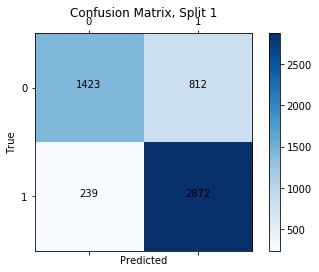

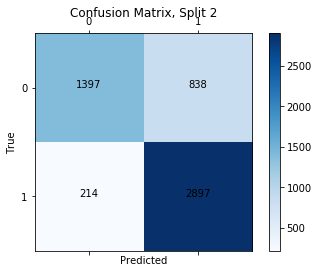

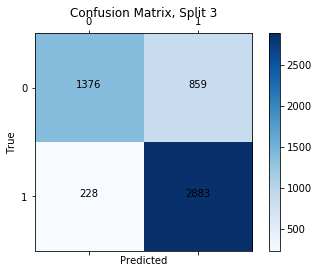

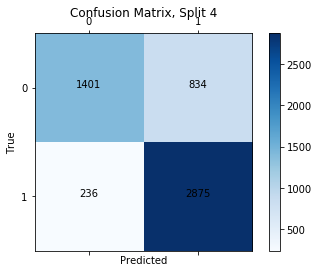

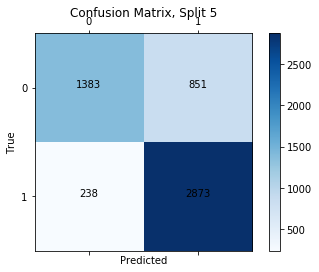

In [101]:
# Check fit of logistic regression.
clf_LR = LogisticRegression()
stratfit(clf_LR, train_data, train_labels_bin, n_splits=5)

Our initial pass with out-of-the-box logistic regression performed well. The weighted f1-scores for both training and test folds were high, at 0.79.

Out of curiosity, we will do a short optimization exercise, but will only pull in the best cases of the model above for other items to evaluate a consistent comparison. Therefore, we will oversample our data and use a random forest classifier throughout. 

As we are creating a new oversampled dataset (to properly weigh our two outcome classes), we have to repeat our PCA analysis as well. However, we want to keep this model similar to our prior model. Therefore, we will be keeping the same number of PCA components as we determined to be optimal above.

In [102]:
# Copying the training data to oversample with only two labels.
train_data_bin = np.copy(train_data)

# Oversample to balance outcome classes.
ros = RandomOverSampler(random_state=0)
train_data_bin_os, train_labels_bin_os = ros.fit_resample(train_data_bin, train_labels_bin)

# Count to double check how many animals are in each class after we employ the RandomOverSampler.
print(sorted(Counter(train_labels_bin_os).items()))

[('Negative', 15555), ('Positive', 15555)]


In [103]:
# Set the number of principal components.
pca = PCA(n_components=30)

# Fit and transform based on train data, but oversampled.
projected_X_train_bin_os = pca.fit_transform(train_data_bin_os)

In [104]:
# This code optimizes a random forest classifier.
clf = RandomForestClassifier()

param = {'max_depth': np.arange(20,120,20)
         , 'min_samples_split': np.arange(4,10,2)
         # , 'n_estimators': np.arange(10, 120, 30)
         , 'criterion': ['gini', 'entropy']}

# Optimize classifier, use f1_weighting, use 5 StratifiedKFolds.
clf_best_param = GridSearchCV(clf, param_grid = param, cv=5, scoring = 'f1_weighted')

# Fit optimized classifier.
clf_best = clf_best_param.fit(projected_X_train_bin_os, train_labels_bin_os)

# Predict on regular data.
# Predict values.
pred_labels = clf_best_param.predict(projected_X_train_bin_os)

print(clf_best.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 6}



TRAIN: 24888 and TEST: 6222

For train data:
               precision    recall  f1-score   support

    Negative       0.89      0.83      0.86     12444
    Positive       0.84      0.90      0.87     12444

   micro avg       0.86      0.86      0.86     24888
   macro avg       0.87      0.86      0.86     24888
weighted avg       0.87      0.86      0.86     24888

For test data:
               precision    recall  f1-score   support

    Negative       0.80      0.74      0.77      3111
    Positive       0.76      0.81      0.78      3111

   micro avg       0.78      0.78      0.78      6222
   macro avg       0.78      0.78      0.78      6222
weighted avg       0.78      0.78      0.78      6222


TRAIN: 24888 and TEST: 6222

For train data:
               precision    recall  f1-score   support

    Negative       0.88      0.84      0.86     12444
    Positive       0.85      0.89      0.87     12444

   micro avg       0.86      0.86      0.86     24888
   macro avg      

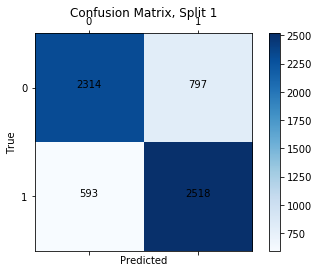

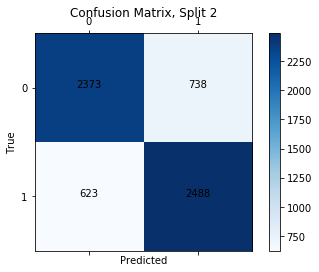

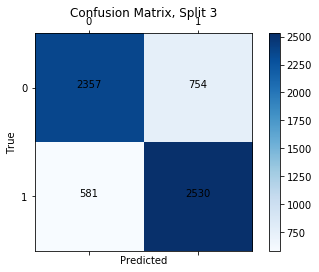

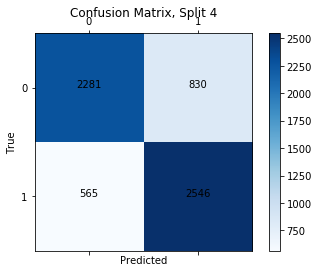

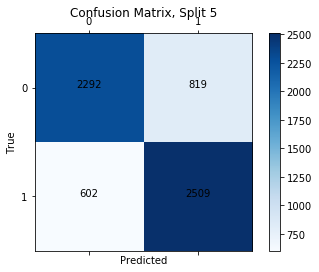

In [105]:
# Run random forest with the best parameters.
clf_RF = RandomForestClassifier(max_depth=40, min_samples_split=6, criterion='gini')
stratfit(clf_RF, projected_X_train_bin_os, train_labels_bin_os, n_splits=5)

We can see that the out-of-the-box logistic regression classifier marginally outperforms the class-balanced and PCA-projected random forest classifier. With binary outcomes, our classes are almost balanced, so oversampling is not strictly necessary. However, we will continue using oversampled data for consistency.

### Error Analysis for Binary Outcomes

In [106]:
# Split training, projected data into training and test. 
indices = np.asarray(range(len(train_data)))
X_train_bin, X_test_bin, y_train_bin, y_test_bin,indices_train_bin,indices_test_bin= train_test_split(train_data
                                                                              , train_labels_bin
                                                                              , indices
                                                                              , test_size = .25
                                                                              , stratify = train_labels_bin
                                                                              , random_state = 99)
print(X_train_bin.shape)
print(X_test_bin.shape)
print(y_train_bin.shape)
print(y_test_bin.shape)
print(indices_train_bin.shape)
print(indices_test_bin.shape)

(20046, 283)
(6683, 283)
(20046,)
(6683,)
(20046,)
(6683,)


Label Legend
0: Negative
1: Positive

Confusion Matrix


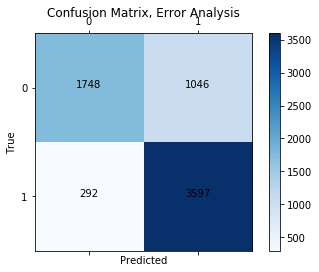

Top Errors:

Positive is predicted when the true value is Negative: 1046 times.

Examples of this error:

Example 1: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Blue Lacy
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Medium Hair
	 Brown Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Labrador Retriever
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 State(Fixed=1)
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Miniature Pinscher
	 Red
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Chihuahua Shorthair
	 Fawn
	 AgeuponOutcome_norm
All other features equal to 0.

Example 7: Non-zero features:
	 

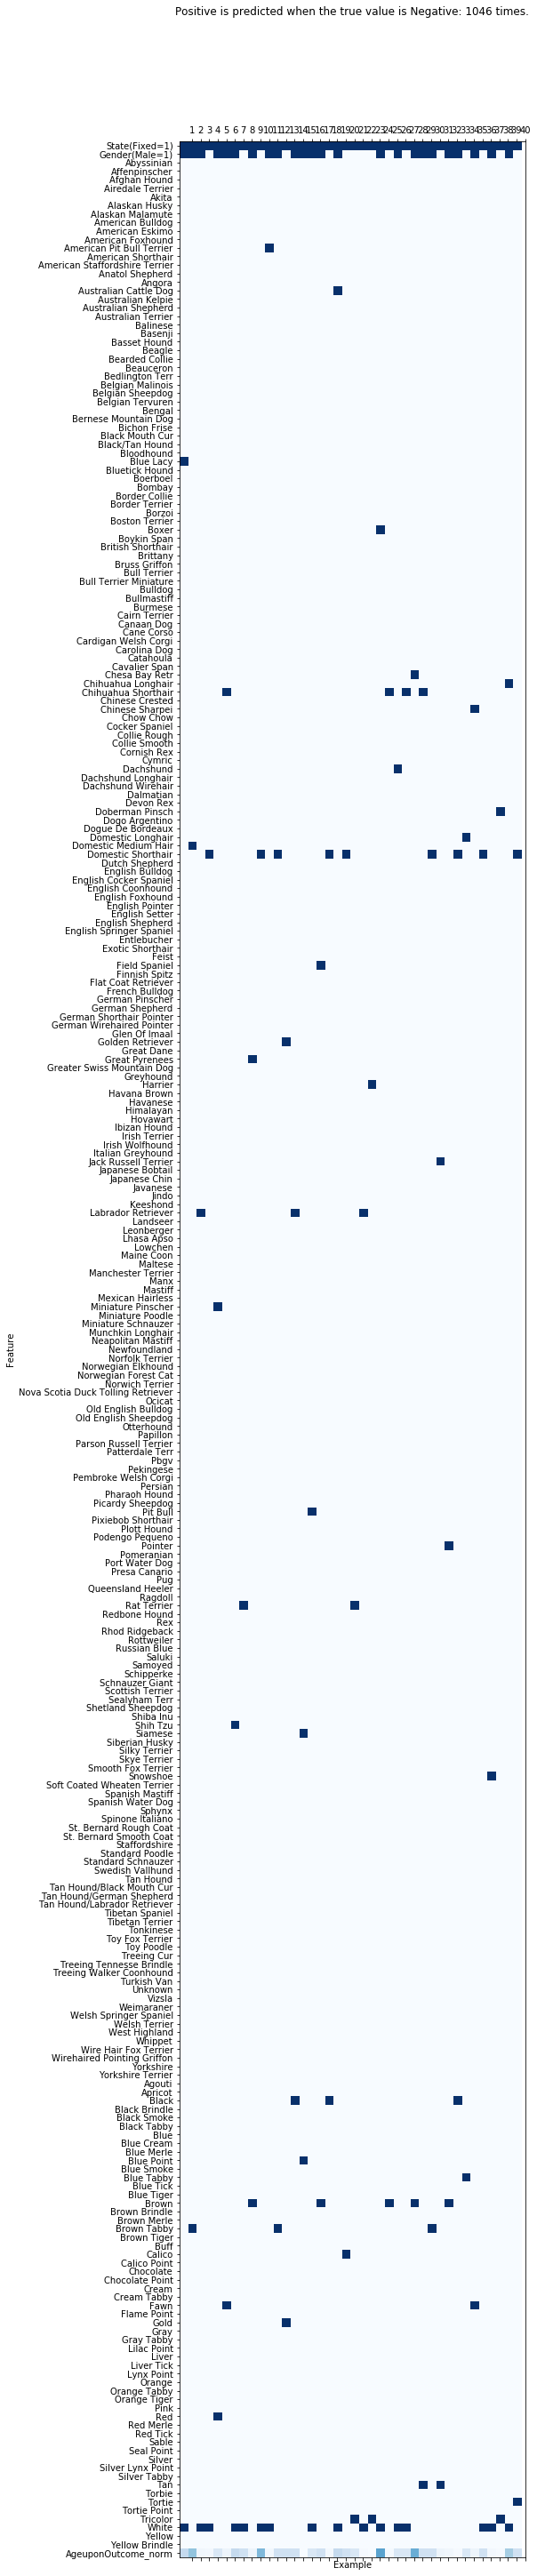

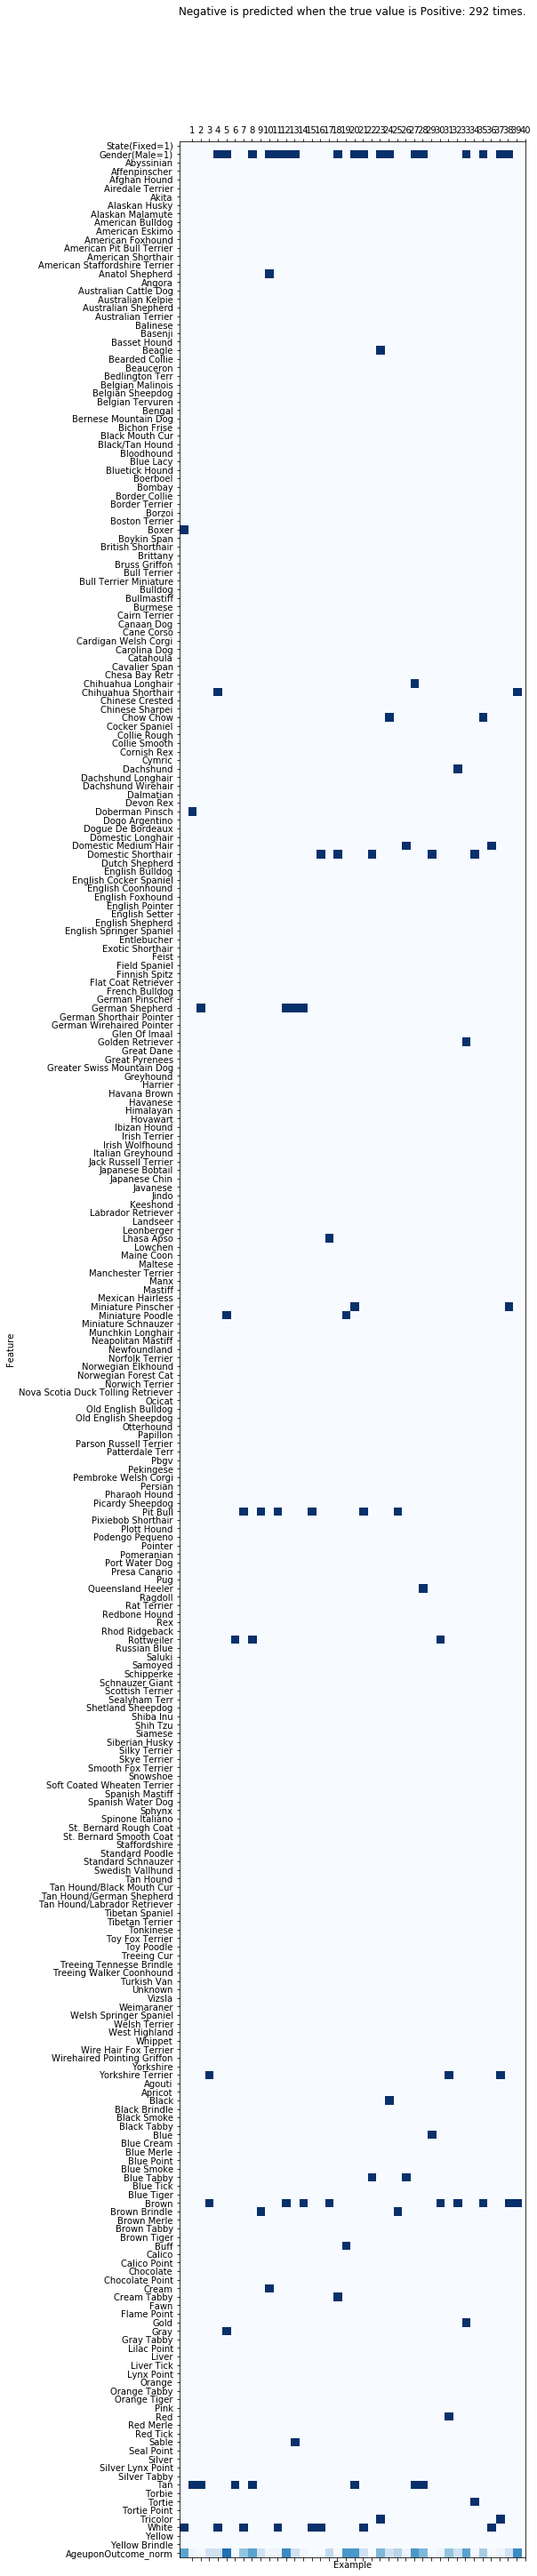

In [107]:
# Run error analysis for LogisticRegression.
clf_LR = LogisticRegression()
clf_LR.fit(X_train_bin, y_train_bin)
pred_labels = clf_LR.predict(X_test_bin)

labels = ['Negative', 'Positive']
find_and_show_errors(fit_labels_true=y_test_bin, train_data=train_data_bin_os
                     , pred_labels=pred_labels,  indices_test=indices_test_bin
                     , labels=labels, N=2, J=40
                    )


Label Legend
0: Negative
1: Positive

Confusion Matrix


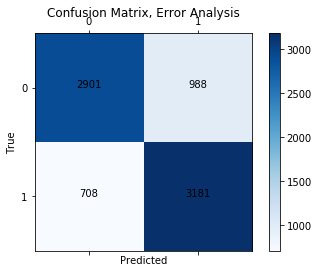

Top Errors:

Positive is predicted when the true value is Negative: 988 times.

Examples of this error:

Example 1: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Brown Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 2: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Pit Bull
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 3: Non-zero features:
	 State(Fixed=1)
	 Pit Bull
	 Brown
	 AgeuponOutcome_norm
All other features equal to 0.

Example 4: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Chihuahua Shorthair
	 Black
	 AgeuponOutcome_norm
All other features equal to 0.

Example 5: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Orange Tabby
	 AgeuponOutcome_norm
All other features equal to 0.

Example 6: Non-zero features:
	 State(Fixed=1)
	 Chihuahua Shorthair
	 Brown
	 AgeuponOutcome_norm
All other features equal to 0.

Example 7: Non-zero features:
	 State(Fixed=1)
	 Chi

	 Gender(Male=1)
	 Domestic Shorthair
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 39: Non-zero features:
	 Gender(Male=1)
	 Patterdale Terr
	 White
	 AgeuponOutcome_norm
All other features equal to 0.

Example 40: Non-zero features:
	 State(Fixed=1)
	 Gender(Male=1)
	 Domestic Shorthair
	 Brown Tabby
	 AgeuponOutcome_norm
All other features equal to 0.



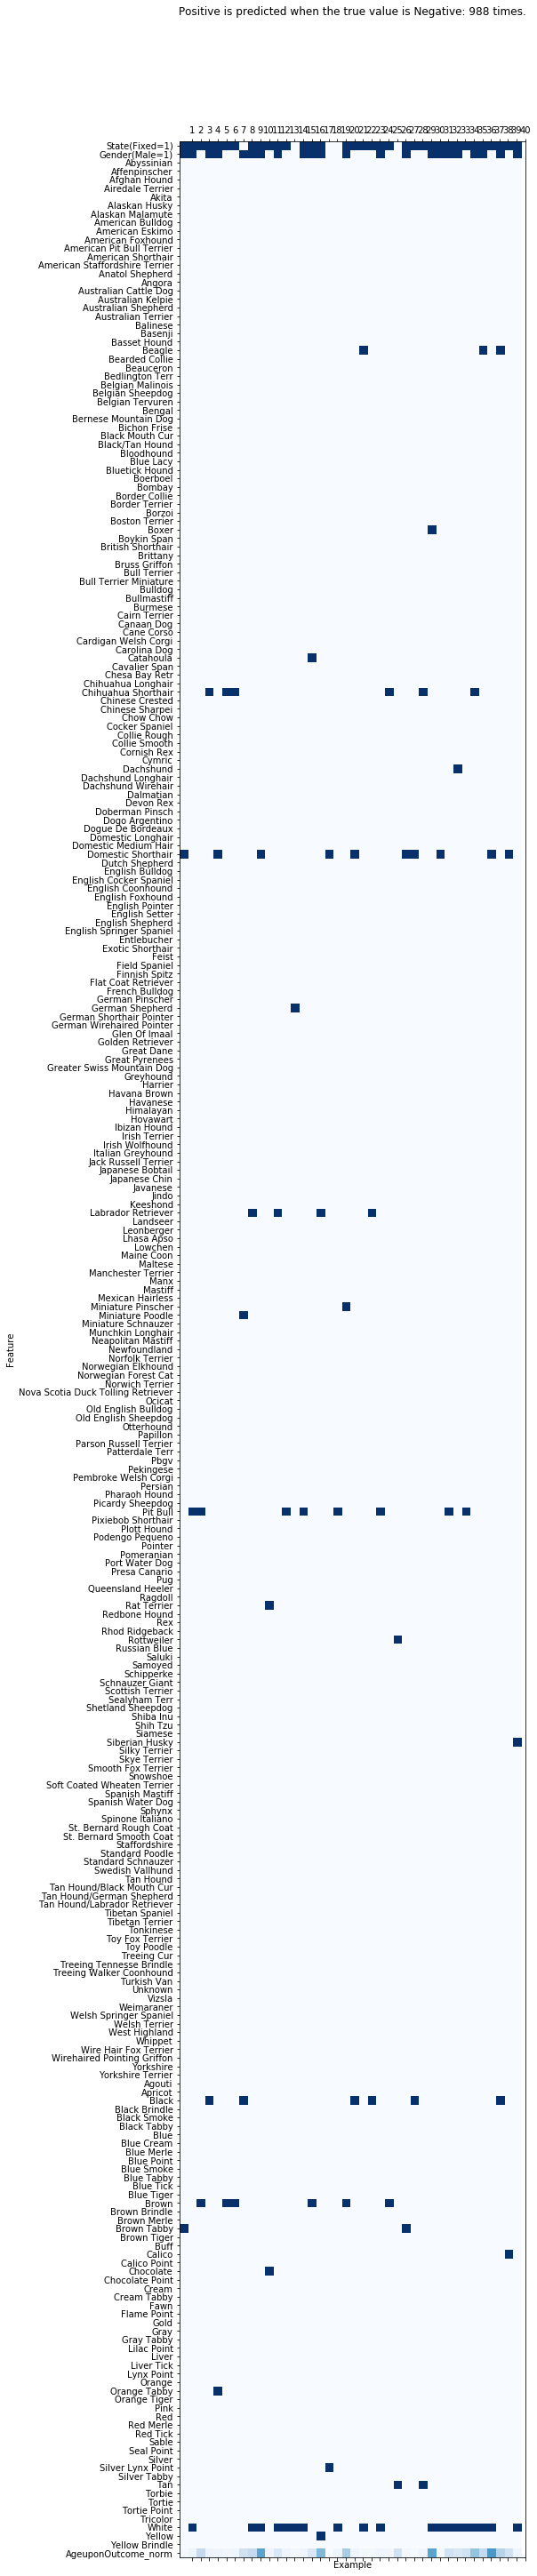

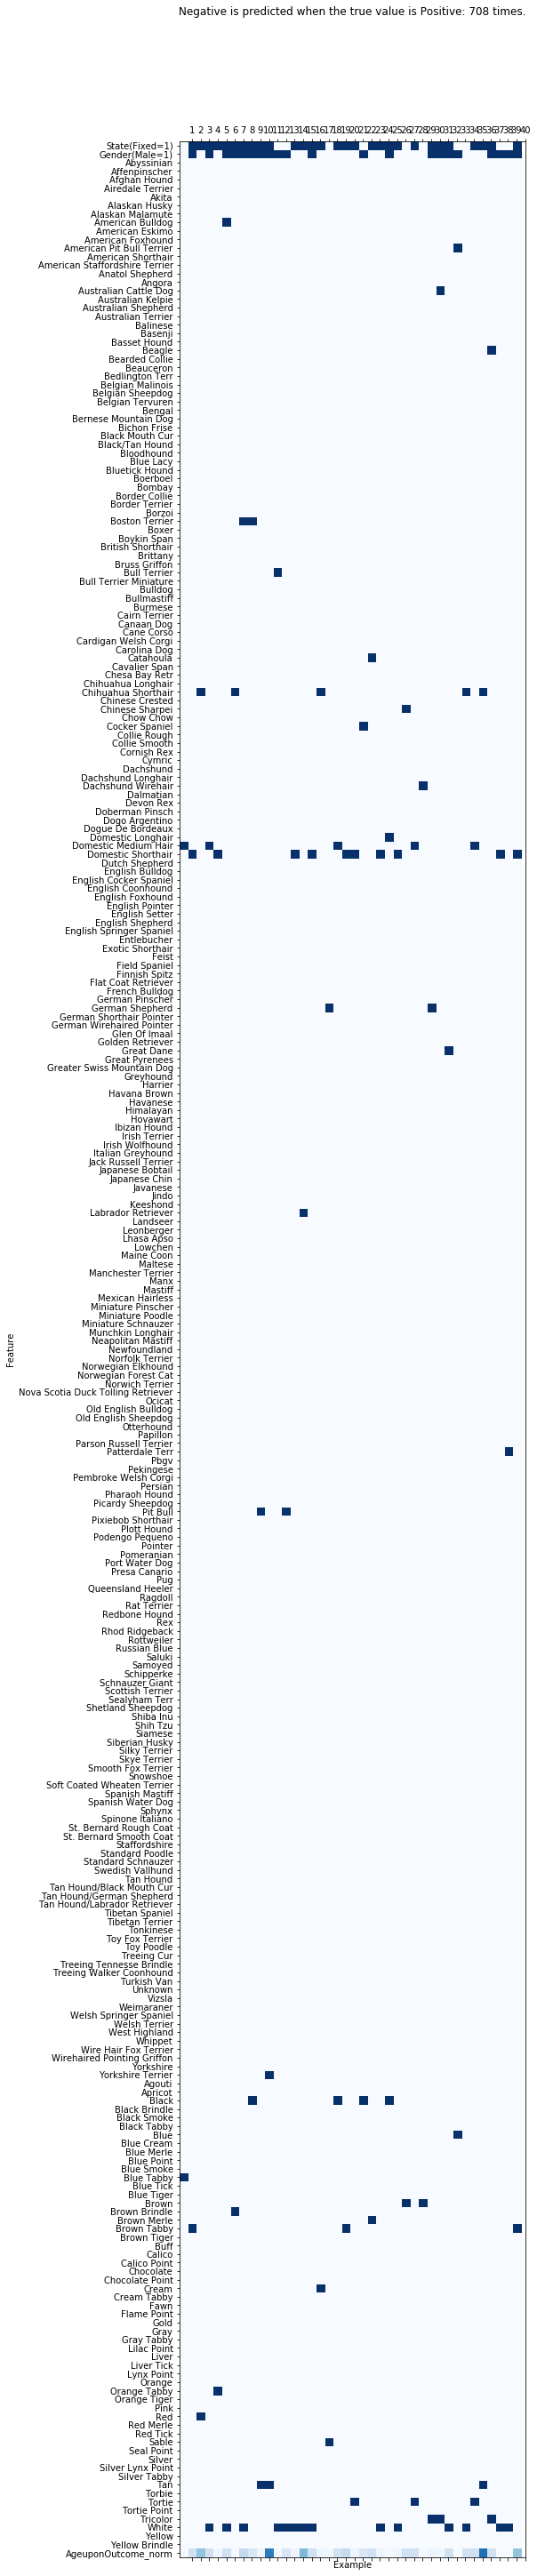

In [108]:
# Run error analysis for random forest.
indices = np.asarray(range(len(projected_X_train_bin_os)))
X_train_bin, X_test_bin, y_train_bin, y_test_bin,indices_train_bin,indices_test_bin= train_test_split(projected_X_train_bin_os
                                                                              , train_labels_bin_os
                                                                              , indices
                                                                              , test_size = .25
                                                                              , stratify = train_labels_bin_os
                                                                              , random_state = 99)

clf_RF = RandomForestClassifier(max_depth=80, min_samples_split=6, criterion='entropy')
clf_RF.fit(X_train_bin, y_train_bin)
pred_labels = clf_RF.predict(X_test_bin)

labels = ['Negative', 'Positive']
find_and_show_errors(fit_labels_true=y_test_bin, train_data=train_data_bin_os
                     , pred_labels=pred_labels,  indices_test=indices_test_bin
                     , labels=labels, N=2, J=40
                    )


If we were to pursue this approach further, we would use this error analysis to guide the feature engineering.

### Log Loss functions for the binary outcomes

In [109]:
# What is the log loss of the "dumb" classifier that predicts all adoption?

# Create numpy array, pred_prob, that predicts all adoption.
pred_prob = np.zeros((len(train_labels_bin),2))
pred_prob[:, 0] = 1
                 
# Calculate and print log_loss metric for the dumb classifier.
log_loss_metric = log_loss(train_labels_bin, pred_prob
                           , labels=['Negative'
                                     , 'Positive'
                                    ]
                          )
print('Log loss for the dumb classifier is {:.2f}.'.format(log_loss_metric))

Log loss for the dumb classifier is 20.10.


In [110]:
# Pick our favorite classifier from above.

indices = np.asarray(range(len(projected_X_train_bin_os)))
X_train_bin, X_test_bin, y_train_bin, y_test_bin,indices_train_bin,indices_test_bin= train_test_split(projected_X_train_bin_os
                                                                              , train_labels_bin_os
                                                                              , indices
                                                                              , test_size = .25
                                                                              , stratify = train_labels_bin_os
                                                                              , random_state = 99)


clf_optimal = RandomForestClassifier(max_depth=60, min_samples_split=4, criterion='gini')
# Fit it.
clf_optimal.fit(X_train_bin, y_train_bin)
# Predict probabilities.
pred_prob = clf_optimal.predict_proba(X_test_bin)

# Calculate and print log_loss metric.
log_loss_metric = log_loss(y_test_bin, pred_prob
                           , labels=['Negative'
                                     , 'Positive'
                                    ]
                          )
print('Log loss for random forest: {:.2f}'.format(log_loss_metric))

Log loss for random forest: 1.18


In [111]:
# Assign the splits again for non-projected data.
indices = np.asarray(range(len(train_data)))
X_train_bin, X_test_bin, y_train_bin, y_test_bin,indices_train_bin,indices_test_bin= train_test_split(train_data
                                                                              , train_labels_bin
                                                                              , indices
                                                                              , test_size = .25
                                                                              , stratify = train_labels_bin
                                                                              , random_state = 99)


# Select LogisticRegression classifier.
clf_optimal = LogisticRegression()
# Fit it.
clf_optimal.fit(X_train_bin, y_train_bin)
# Predict probabilities.
pred_prob = clf_optimal.predict_proba(X_test_bin)

# Calculate and print log_loss metric.
log_loss_metric = log_loss(y_test_bin, pred_prob
                           , labels=['Negative'
                                     , 'Positive'
                                    ]
                          )
print('Log loss for logistic regression: {:.2f}'.format(log_loss_metric))

Log loss for logistic regression: 0.49


The error analysis returned a log loss of 1.17 for random forest, a notable improvement over the five-class result, and 0.49 for logistic regression, which is substantially better than our best model using all outcome classes. It makes intuitive sense that we would see better-performing models, as we simplified the outcome classes. However, we would argue that this model, predicting only positive and negative outcomes, would actually be more valuable to shelters. If we were to work with shelters to implement further study of this topic, we would recommend the binary approach.

**Bibliography**
- “Assessment-of-Storefront-Displays-with-a-Multidisciplinary-Approach-Based-on-Neuromarketing-and-Antropological-Marketing.Pdf.” Accessed November 11, 2018. https://www.researchgate.net/profile/Maurizio_Mauri3/publication/328163427_Assessment_of_Storefront_Displays_with_a_Multidisciplinary_Approach_based_on_Neuromarketing_and_Antropological_Marketing/links/5bbc74a4a6fdcc9552dcb5e1/Assessment-of-Storefront-Displays-with-a-Multidisciplinary-Approach-based-on-Neuromarketing-and-Antropological-Marketing.pdf#page=259.
- Chen, Tianqi and Guestrin, Carlos. “XGBooost: A Scalable Tree Boosting System.” SIGKDD. 2016. https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf
- Domke, Justin. “Structured Learning via Logistic Regression.” ArXiv:1407.0754 [Cs, Stat], July 2, 2014. http://arxiv.org/abs/1407.0754.
- Fernandez-Delgado, Manuel, Eva Cernadas, Senen Barro, and Dinani Amorim. “Do We Need Hundreds of Classiﬁers to Solve Real World Classiﬁcation Problems?,” n.d., 49.
- Galar, M., A. Fernandez, E. Barrenechea, H. Bustince, and F. Herrera. “A Review on Ensembles for the Class Imbalance Problem: Bagging-, Boosting-, and Hybrid-Based Approaches.” IEEE Transactions on Systems, Man, and Cybernetics, Part C (Applications and Reviews) 42, no. 4 (July 2012): 463–84. https://doi.org/10.1109/TSMCC.2011.2161285.
- Gultepe, Eren, Jeffrey P. Green, Hien Nguyen, Jason Adams, Timothy Albertson, and Ilias Tagkopoulos. “From Vital Signs to Clinical Outcomes for Patients with Sepsis: A Machine Learning Basis for a Clinical Decision Support System.” Journal of the American Medical Informatics Association: JAMIA 21, no. 2 (April 2014): 315–25. https://doi.org/10.1136/amiajnl-2013-001815.
- Hawes, Sloane, Josephine Kerrigan, and Kevin Morris. “Factors Informing Outcomes for Older Cats and Dogs in Animal Shelters.” Animals 8, no. 3 (March 7, 2018): 36. https://doi.org/10.3390/ani8030036.
- Liaw, Andy, and Matthew Wiener. “Classification and Regression by RandomForest.” Forest 23 (November 30, 2001).
- Makridakis, Spyros, Evangelos Spiliotis, and Vassilios Assimakopoulos. “Statistical and Machine Learning Forecasting Methods: Concerns and Ways Forward.” PLOS ONE 13, no. 3 (March 27, 2018): e0194889. https://doi.org/10.1371/journal.pone.0194889.
- Pavlyshenko, B. “Machine Learning, Linear and Bayesian Models for Logistic Regression in Failure Detection Problems.” In 2016 IEEE International Conference on Big Data (Big Data), 2046–50, 2016. https://doi.org/10.1109/BigData.2016.7840828.
- “Randomforest2001.Pdf.” Accessed November 11, 2018. https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf.
- Ruiz, Anne, and Nathalie Villa. “Storms Prediction : Logistic Regression vs Random Forest for Unbalanced Data.” ArXiv:0804.0650 [Math, Stat], April 4, 2008. http://arxiv.org/abs/0804.0650.
- “Scikit-Learn: Machine Learning in Python — Scikit-Learn 0.20.1 Documentation.” Accessed December 11, 2018. https://scikit-learn.org/stable/.
- SONG, Yan-yan, and Ying LU. “Decision Tree Methods: Applications for Classification and Prediction.” Shanghai Archives of Psychiatry 27, no. 2 (April 25, 2015): 130–35. https://doi.org/10.11919/j.issn.1002-0829.215044.
- “Tidy Data | Wickham | Journal of Statistical Software.” Accessed November 11, 2018. https://doi.org/10.18637/jss.v059.i10.